In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import warnings
from math import log10
warnings.filterwarnings("ignore")

sys.path.append('../plugins')


import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import scipy.stats as stats
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.ensemble import IsolationForest

from steps.clean_flats import iqr_filter



pd.set_option('display.max_rows', 100)
sns.set_theme(context='talk', style="darkgrid", palette='dark', font='sans-serif')
tqdm.pandas()

# 1. Reading data

In [3]:
load_dotenv()

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')

In [4]:
df = pd.read_sql(f'select * from prepared_flats', dst_conn).drop('id', axis=1)

In [5]:
df

,flat_id,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,target,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,117449,2,False,8.50,38.099998,3,False,59.000000,31000000.0,448,1927,1,55.753902,37.602535,3.50,25,8,True
1,117450,12,False,9.00,19.500000,1,False,34.099998,9999999.0,13500,1982,4,55.579052,37.601257,2.48,110,16,True
2,117451,1,False,10.00,20.000000,1,False,38.000000,8500000.0,13762,1983,0,55.705357,37.613846,2.70,108,16,True
3,117452,8,False,24.00,46.000000,3,False,86.500000,19500000.0,24593,2021,2,55.770290,37.473671,3.00,629,25,True
4,117453,16,False,10.00,19.000000,1,False,35.000000,10590000.0,13759,1982,6,55.826427,37.575989,2.48,251,16,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141357,92052,2,False,23.00,32.000000,2,False,55.000000,12399000.0,7017,1967,1,55.847813,37.646290,2.64,287,9,True
141358,92053,1,False,6.00,20.000000,1,False,31.600000,6000000.0,6103,1965,4,55.818752,37.804710,2.64,138,5,False
141359,92054,14,False,21.50,68.199997,3,False,133.000000,19000000.0,21622,2010,4,55.588226,37.372089,2.74,96,25,True
141360,92055,9,False,9.13,32.119999,2,False,54.400002,14300000.0,18975,2003,4,55.671158,37.762211,2.64,136,17,True


# 2. Duplicates

In [6]:
cols = list(df.columns)
cols.remove('flat_id')

is_duplicated_id = df.duplicated(subset=['flat_id'], keep=False)
is_duplicated_features = df[cols].duplicated(keep=False)
print('Number of duplicates along flat_id: ', sum(is_duplicated_id)) 
print('Number of duplicates along other columns: ', sum(is_duplicated_features))
print('Ratio of duplicates along flat_id: ', sum(is_duplicated_id)/len(df)) 
print('Ratio of duplicates along other columns: ', sum(is_duplicated_features)/len(df))

Number of duplicates along flat_id:  0
Number of duplicates along other columns:  17425
Ratio of duplicates along flat_id:  0.0
Ratio of duplicates along other columns:  0.12326509245766189


There are no duplicates along flat_id but nevertheless there are  
a lot of them (about 12 %) if to consider other columns as the subset.   
This probably happened due to the way the data was collected - there  
were different sources of the data and somehow their points of interest  
were intersecting.  
Since the duplicates ratio is quite huge, it is better to keep one of  
the duplicates and make a new column named 'is_duplicated' which is denoted as:  
    - True if the observation was duplicated  
    - False if the observation was unique  
It is likely, that flats that were duplicated in the data are somewhat  
popular and have occured more often than others on the websites which also  
might affect the price of the flat.

In [7]:
df['is_duplicated'] = is_duplicated_features
df.drop_duplicates(subset=cols, keep='first', inplace=True)

Check one more time if there are any duplicates left

In [8]:
is_duplicated_id = df.duplicated(subset=['flat_id'], keep=False)
is_duplicated_features = df[cols].duplicated(keep=False)
print('Number of duplicates along flat_id: ', sum(is_duplicated_id)) 
print('Number of duplicates along other columns: ', sum(is_duplicated_features))
print('Ratio of duplicates along flat_id: ', sum(is_duplicated_id)/len(df)) 
print('Ratio of duplicates along other columns: ', sum(is_duplicated_features)/len(df))

Number of duplicates along flat_id:  0
Number of duplicates along other columns:  0
Ratio of duplicates along flat_id:  0.0
Ratio of duplicates along other columns:  0.0


# 3. Missing data

In [9]:
for col in df.columns:
    n_null = df[col].isnull().sum()
    if n_null > 0:
        print(col, n_null)

There are no missing data in any column.  
In case if any missing data somehow passed,  
the corresponding rows will be dropped.  
On the other hand, it is probably good to make a callback to check   
if a future data will have any missing values.

# 4. Outliers

In [10]:
message = lambda df, df2: print(f"Removed {len(df) - len(df2)} outliers, ratio - {round(100 * (len(df) - len(df2)) / len(df), 2)}%")
threshold = 3

Let's separate features into the following groups:
- numerical features
- binary categorical features
- non-binary categorical features

In [11]:
df.nunique()

flat_id              132246
floor                    56
is_apartment              2
kitchen_area           1036
living_area            2345
rooms                    14
studio                    1
total_area             3358
target                 8384
building_id           24620
build_year              118
building_type_int         7
latitude              15720
longitude             15271
ceiling_height           77
flats_count             706
floors_total             64
has_elevator              2
is_duplicated             2
dtype: int64

In [12]:
df.dtypes

flat_id                int64
floor                  int64
is_apartment            bool
kitchen_area         float64
living_area          float64
rooms                  int64
studio                  bool
total_area           float64
target               float64
building_id            int64
build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator            bool
is_duplicated           bool
dtype: object

In [13]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
binary_cat_features = df.columns[df.nunique() == 2].to_list()
non_binary_cat_features = ['building_type_int']

for col in ['flat_id', 'building_id', 'building_type_int']:
    numerical_features.remove(col)

## I. One-dimensional outliers

In [14]:
iqr_features = {}
queries = []

### A. Binary categorical features

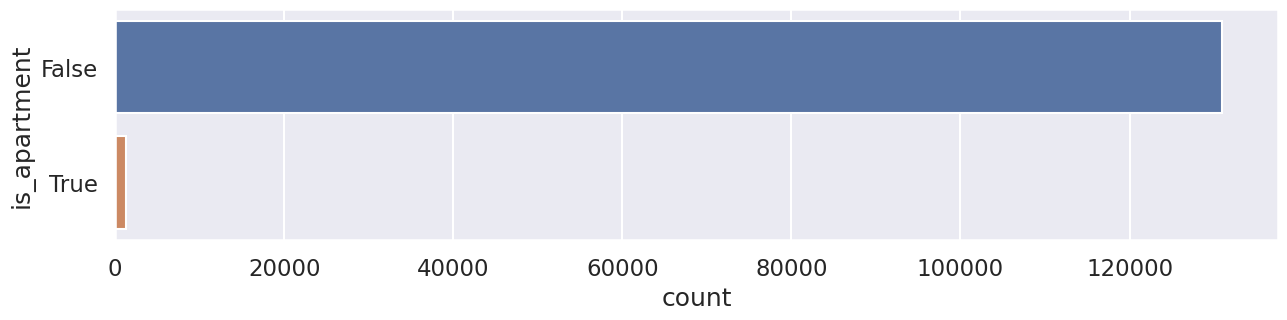

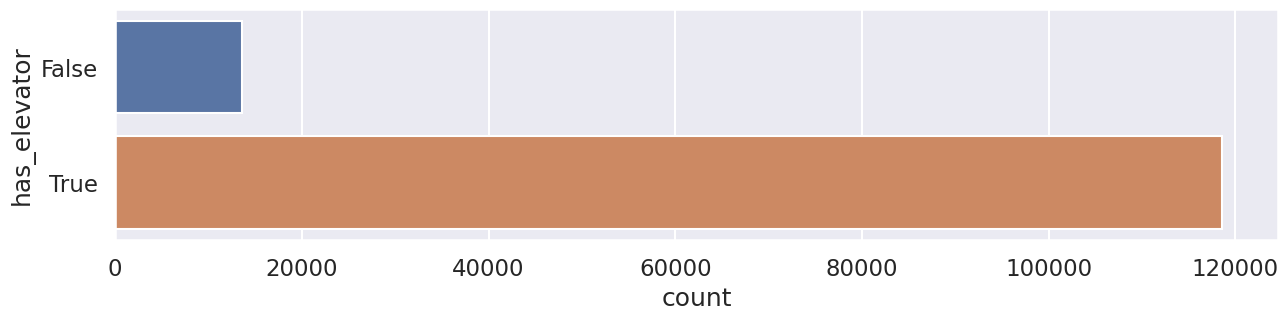

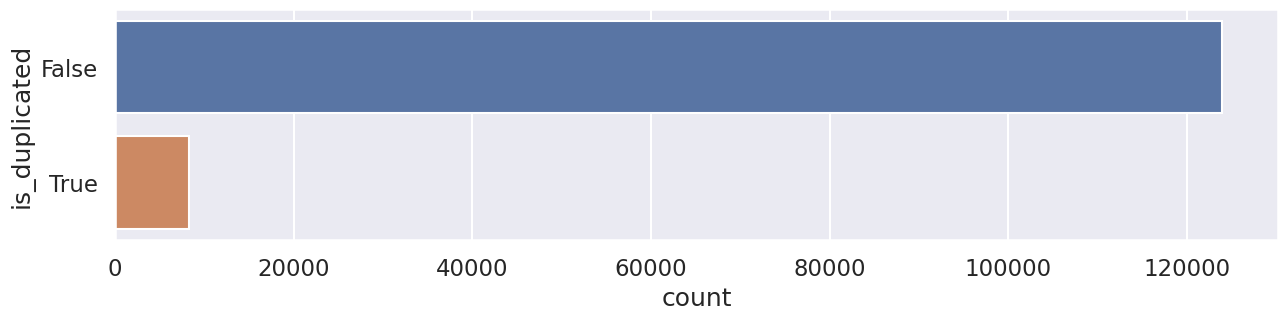

In [15]:
for feat in binary_cat_features:
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    sns.countplot(data=df[feat], ax=ax, orient='horizontal', palette='deep')

There are no outliers in the provided features

### B. Non-binary categorical features

[2024-08-28T17:42:02.089+0000] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-08-28T17:42:02.268+0000] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


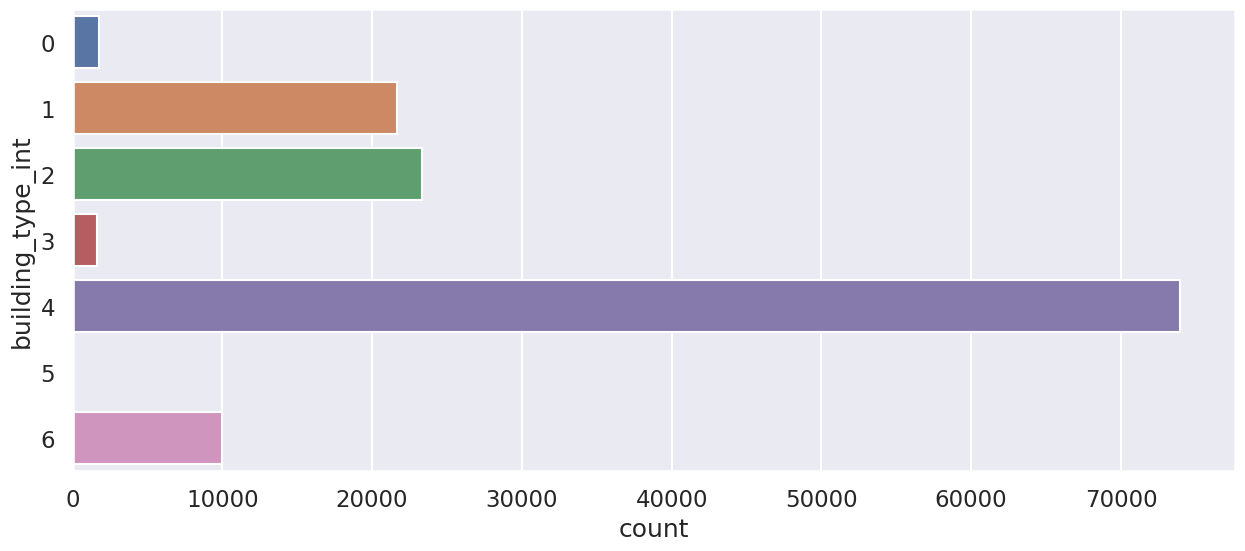

In [16]:
for feat in non_binary_cat_features:
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    sns.countplot(data=df[feat], ax=ax, orient='horizontal', palette='deep')

In [17]:
for feat in non_binary_cat_features:
    print(df[feat].value_counts())

building_type_int
4    73922
2    23305
1    21649
6     9958
0     1766
3     1642
5        4
Name: count, dtype: int64


We can clearly see, that building type 5 has almost no observations, which indicates  
that it is an outlier. Since it is not known from the data what building type corresponds  
 to each number and it is only 4 observations, let's just drop them

In [18]:
query = 'building_type_int != 5 | building_type_int.isna()'
queries.append(query)
message(df, df.query(query))

Removed 4 outliers, ratio - 0.0%


### C. Numerical features

In [19]:
def get_bins(x: int) -> int:
    """
    Calculates the appropriate number of bins for the histogram
    according to the number of the observations

    Args:
        x (int):
            Number of the observations

    Returns:
        int:
            Number of bins
    """
    if x > 0:
        n_bins = max(int(1 + 3.2 * np.log(x)), int(1.72 * x ** (1 / 3)))
    else:
        message = (
            "An invalid input value passed. Expected a positive "
            + "integer, but got {x}"
        )
        raise ValueError(message)
    return n_bins


def hist_box_plot(
    df: pd.DataFrame, feature: str, kde: bool = False, label: str | None = None
) -> None:
    """
    Plots a histogram and box plot for a given feature in a DataFrame.

    Args:
        df (pd.DataFrame):
            The input DataFrame.
        feature (str):
            The column name of the feature to plot.
        kde (bool, optional):
            Whether to plot a kernel density estimate on the histogram.
            Defaults to False.
        label (str, optional):
            The label to use for the feature.
            If not provided, the feature name will be used.
    """
    if label == None:
        label = feature
    data = df[feature].dropna()
    plt.figure(figsize=(15, 6))
    sns.histplot(data, bins=get_bins(len(data)), kde=kde)
    plt.xlabel(label)
    plt.figure(figsize=(15, 3))
    sns.boxplot(data, orient="h")
    plt.xlabel(label)

#### Target (price)

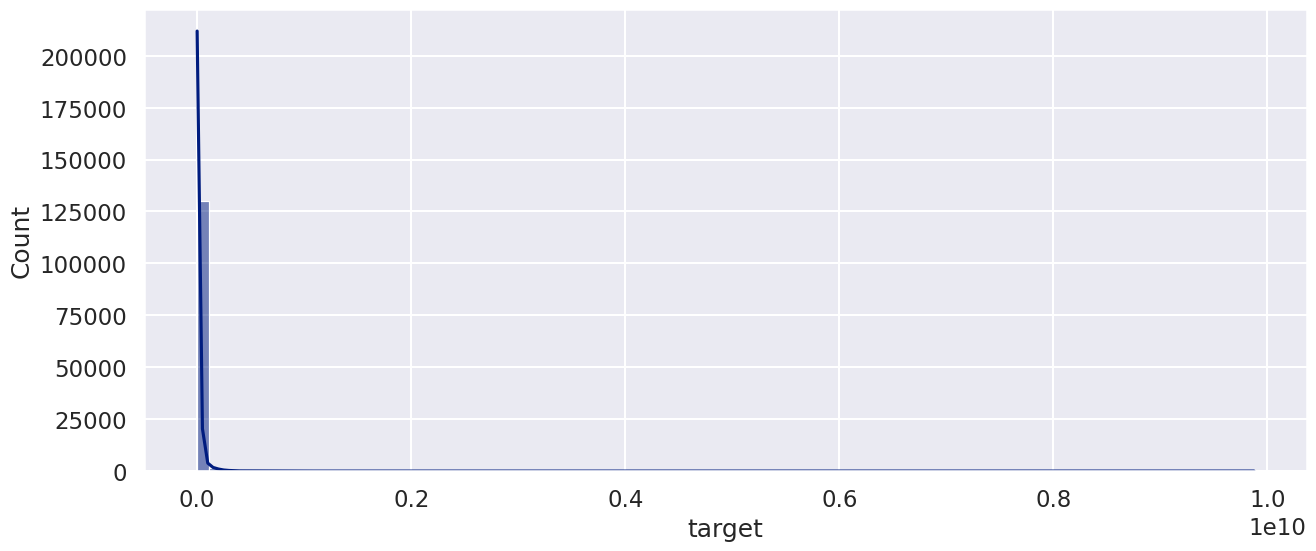

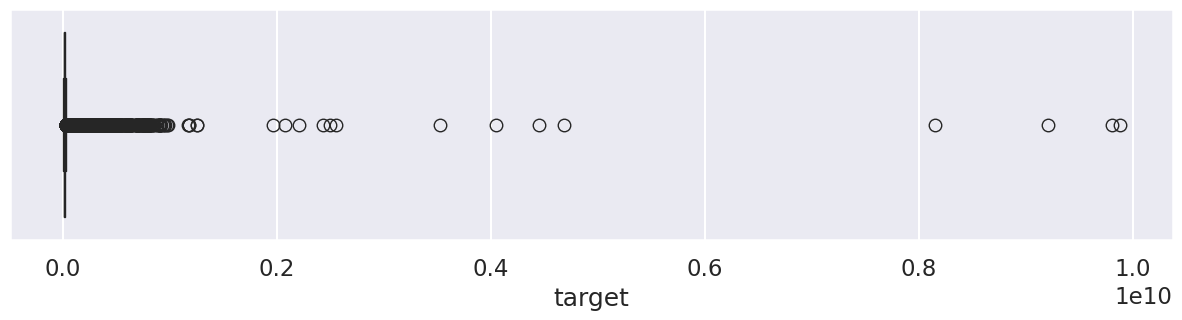

In [20]:
hist_box_plot(df=df, feature='target', kde=True)

It is a good practice for this kind of features to apply log1p transformation. In our case: 
$$ logprice = log_{10}(1 + price) $$  
The new feature is also easily interpretable - it denotes the order of magnitude of the price.  
However, this feature will be transformed back when making predictions or calculatung metrics

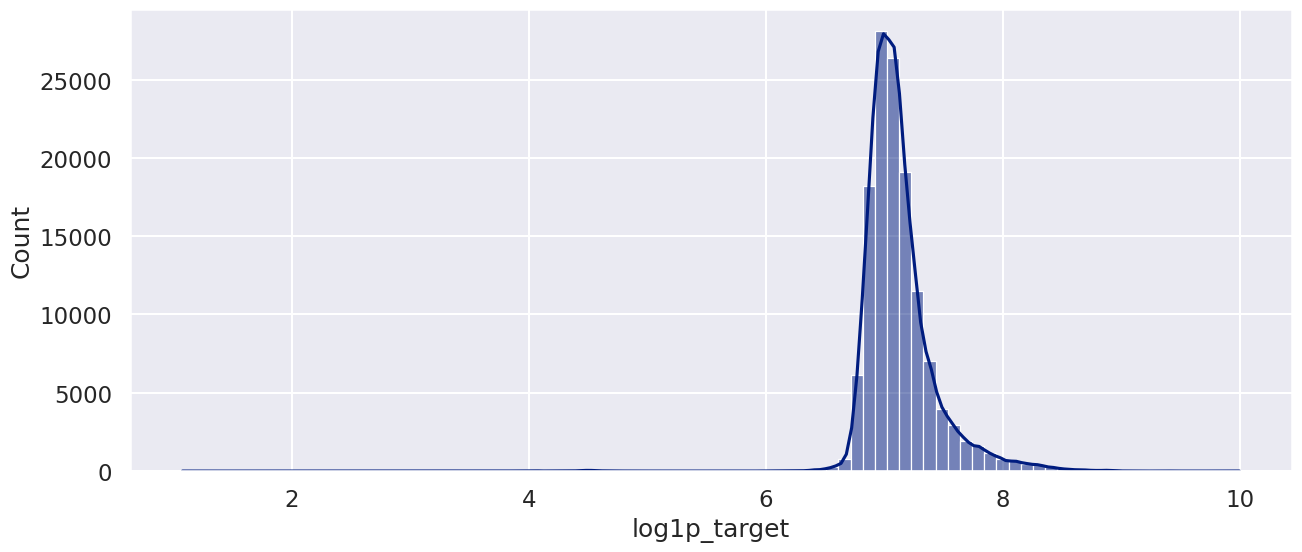

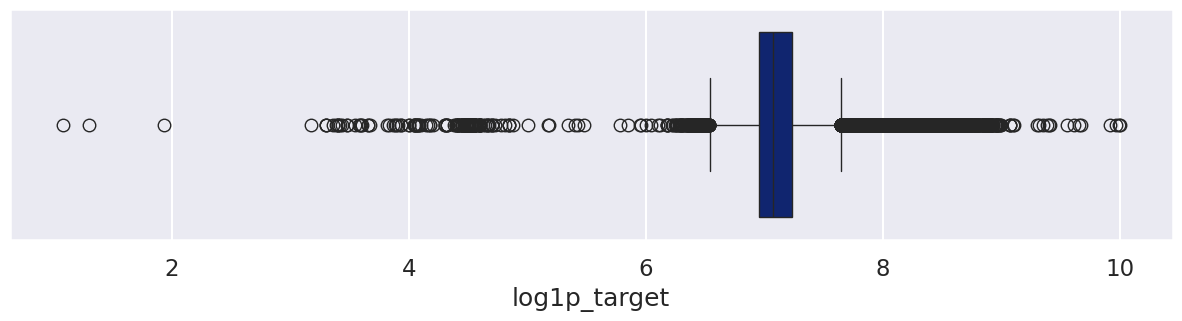

In [21]:
df['log1p_target'] = df['target'].apply(lambda x: log10(1 + x))
hist_box_plot(df=df, feature='log1p_target', kde=True)

There are quite some extreme values in the distribution which would harm the perfomance  
of the ML model. Let's deal with them via IQR method.  
$threshold$ is equal to 4 instead of 1.5 so that only too extreme values are removed

Removed 844 outliers, ratio - 0.64%


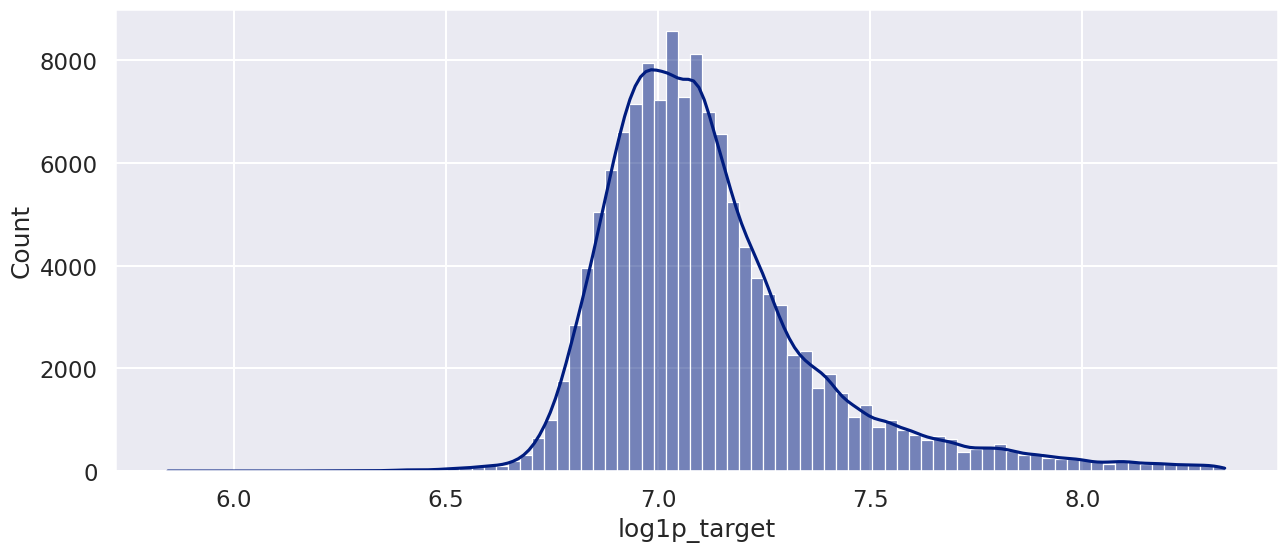

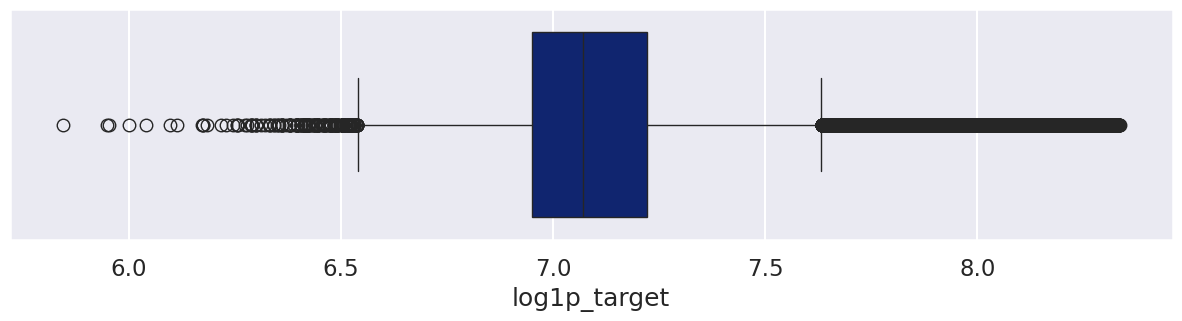

In [22]:
col = 'log1p_target'
iqr_features[col] = 4
df2 = iqr_filter(df.copy(), features={col: iqr_features[col]})
hist_box_plot(df=df2, feature=col, kde=True)

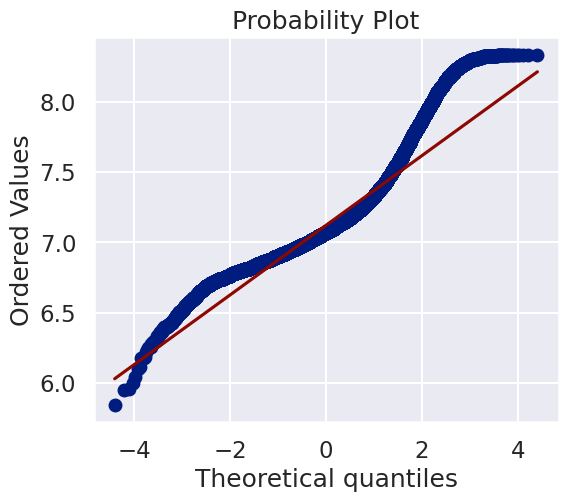

In [23]:
plt.figure(figsize=(6, 5))
stats.probplot(df2['log1p_target'], dist="norm", plot=plt)
plt.show()

The resulting distribution is close to normal except for heavy right tail and very shallow left tail.  
New feature 'log1p_target' will be considered as a target features instead of 'target'  
due to distributions reasons.  
It will be necessary to apply inverse transformation to the predictions later

In [24]:
numerical_features.remove('target')
numerical_features.append('log1p_target')

#### latitude & longitude

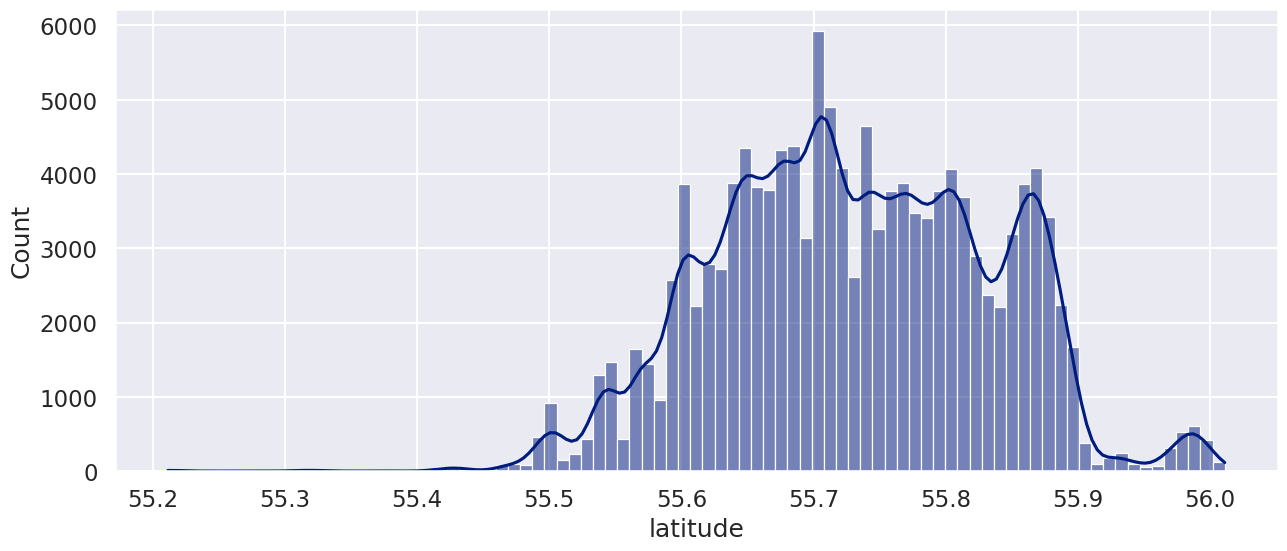

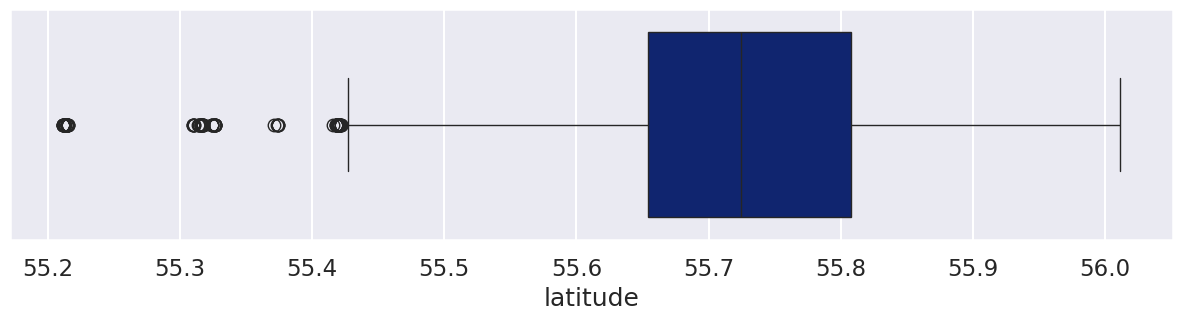

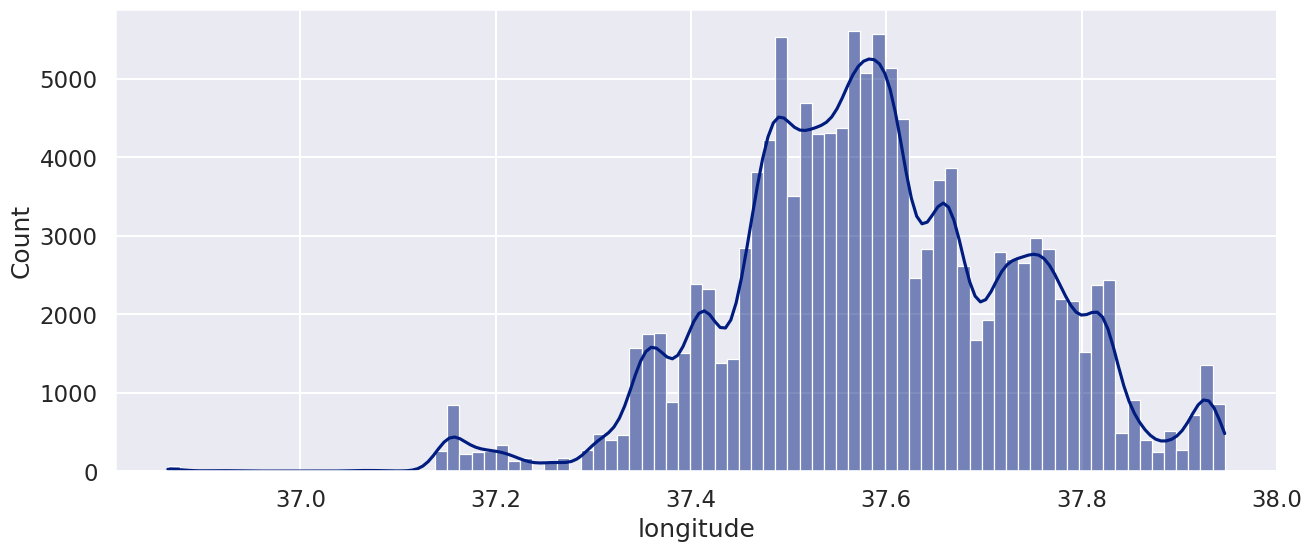

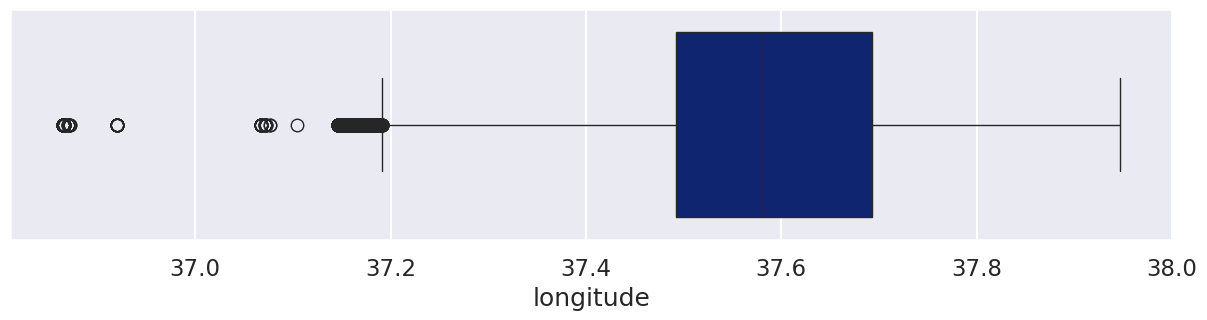

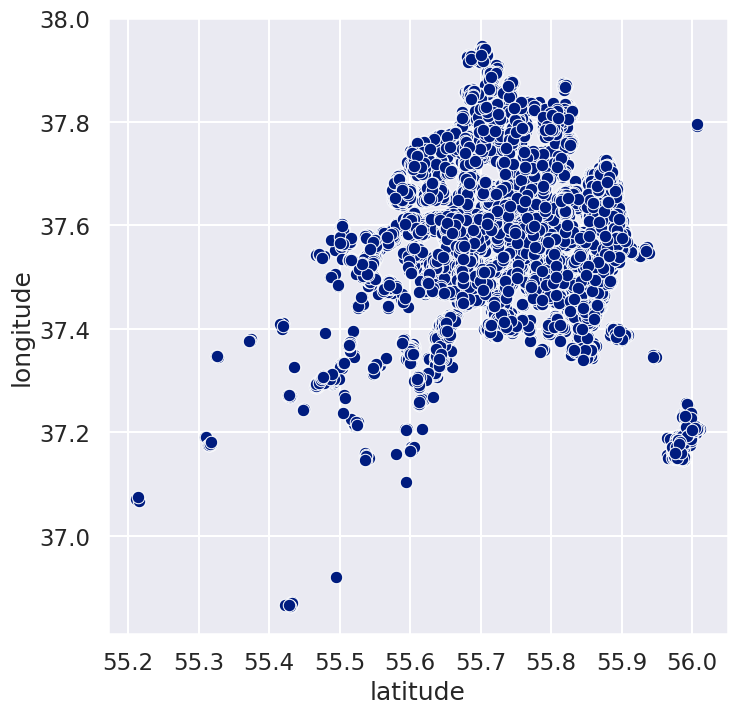

In [25]:
hist_box_plot(df=df, feature='latitude', kde=True)
hist_box_plot(df=df, feature='longitude', kde=True)

coords = df[['latitude', 'longitude']].drop_duplicates()
plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x=coords['latitude'], y=coords['longitude'])
plt.show()

According to the coordinates, it is Moscow  
There are clearly some outliers, especially in the south-west part of the map.  


Let's apply IQR filter with a default $threshold$ = 1.5 for latitude

Removed 109 outliers, ratio - 0.08%


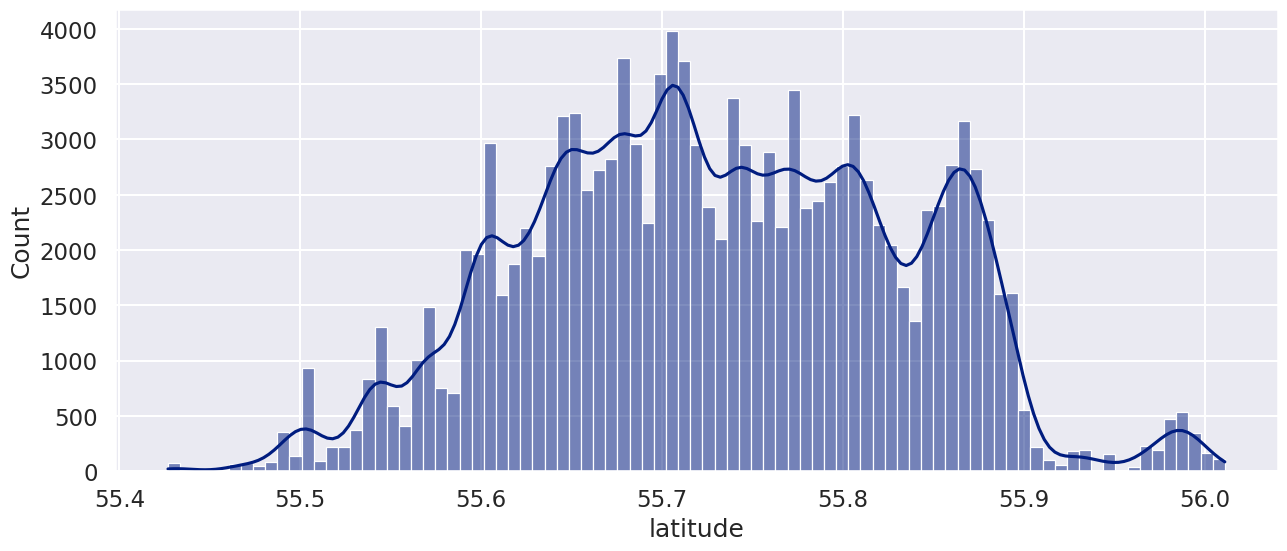

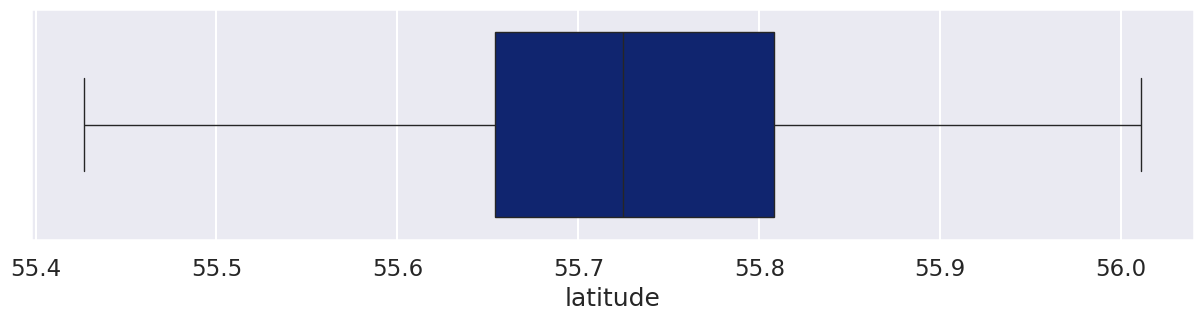

In [26]:
col = 'latitude'
iqr_features[col] = 1.5
hist_box_plot(df=iqr_filter(df.copy(), features={col: iqr_features[col]}), feature=col, kde=True)

Let's apply IQR filter with a higher $threshold$ = 2 for longitude so that not many data is removed.

Removed 103 outliers, ratio - 0.08%


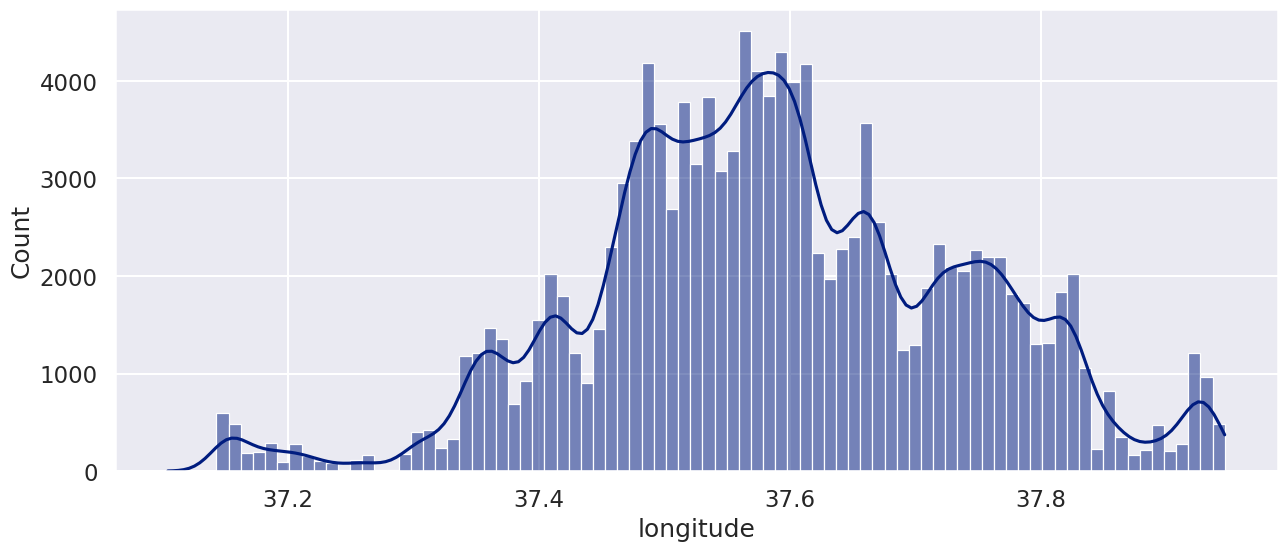

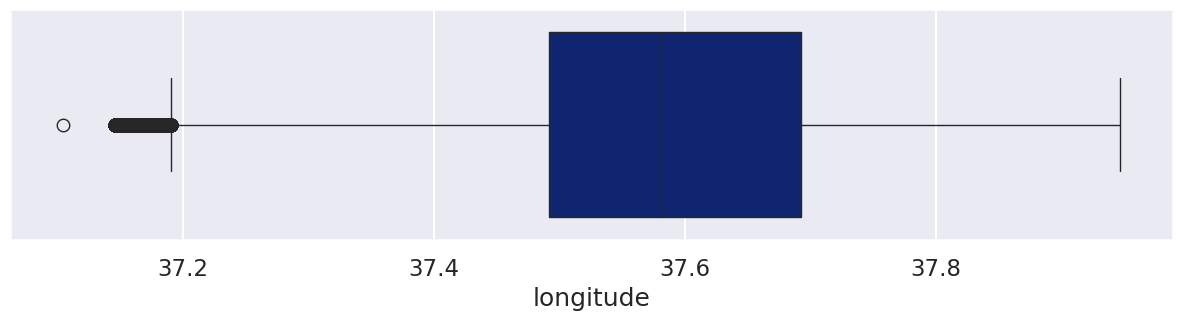

In [27]:
col = 'longitude'
iqr_features[col] = 2
hist_box_plot(df=iqr_filter(df.copy(), features={col: iqr_features[col]}), feature=col, kde=True)

Let's check the map

Removed 186 outliers, ratio - 0.14%


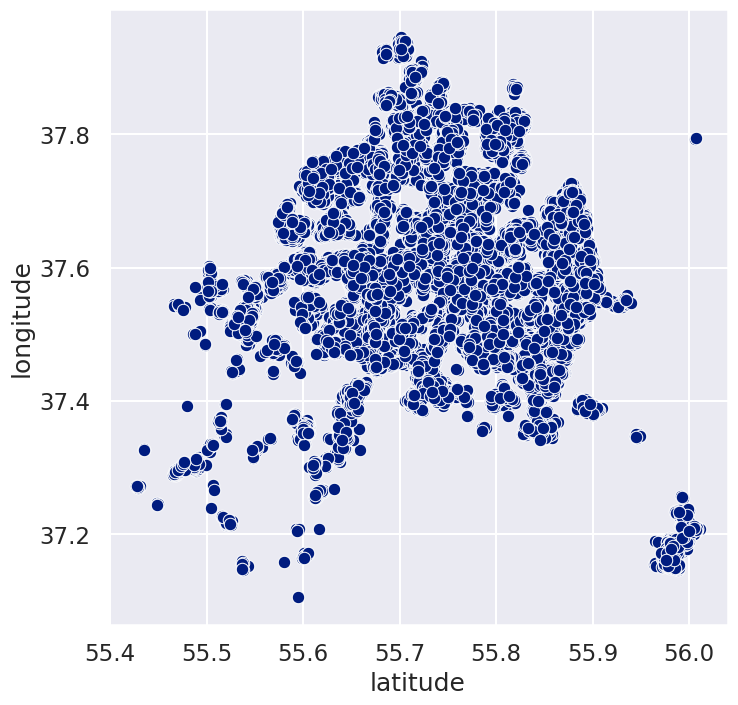

In [28]:
df2 = iqr_filter(df.copy(), features={'latitude': iqr_features['latitude'], 'longitude': iqr_features['longitude']})

coords = df2[['latitude', 'longitude']].drop_duplicates()
plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x=coords['latitude'], y=coords['longitude'])
plt.show()

As a result, properties which are located too fat from the Moscow have been removed from the data.

#### total_area, living_area, kitchen_area

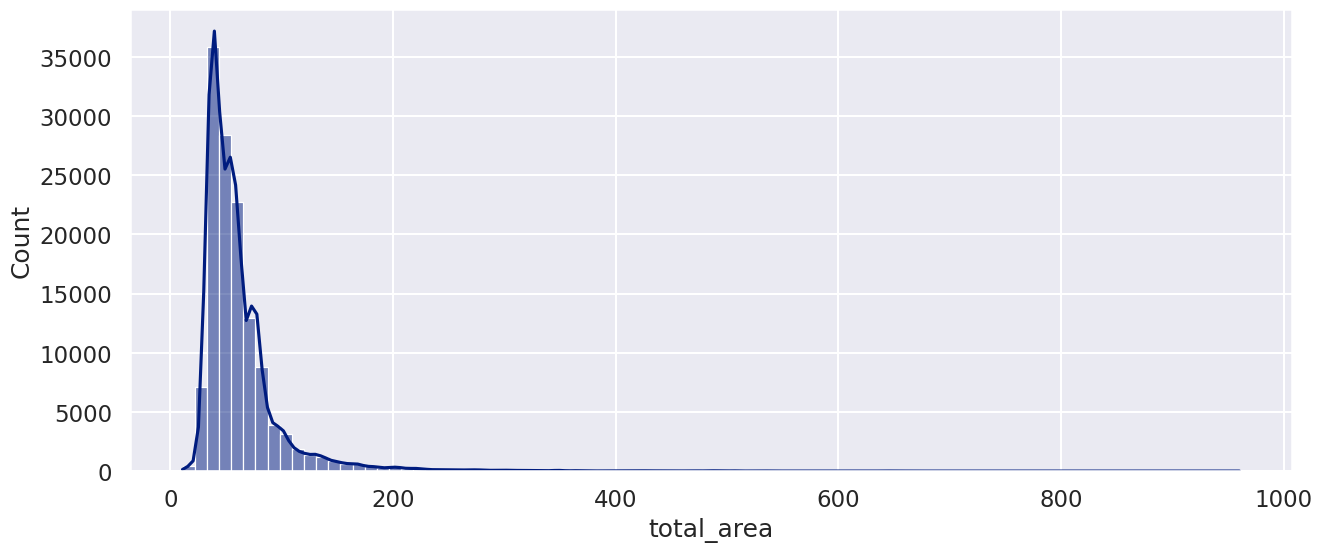

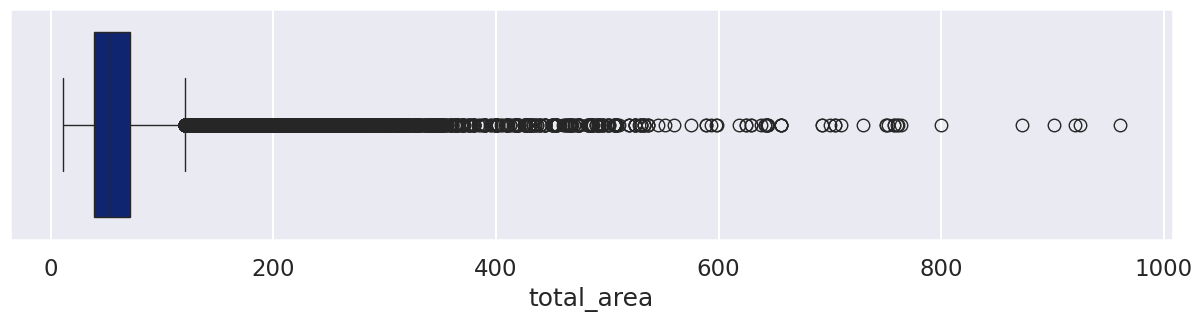

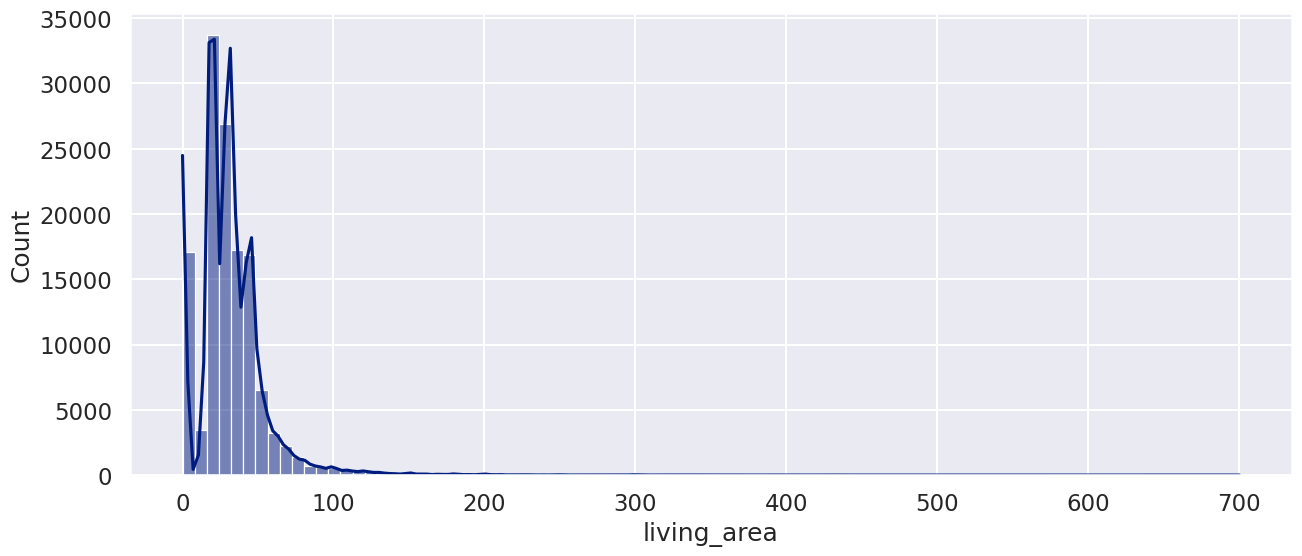

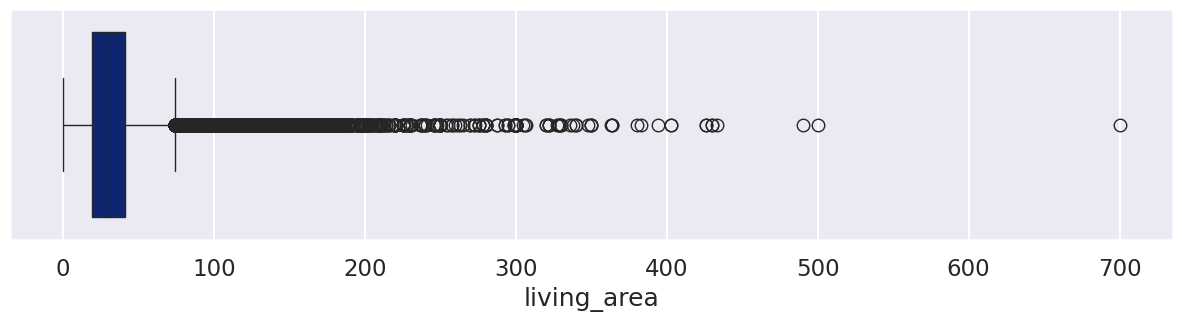

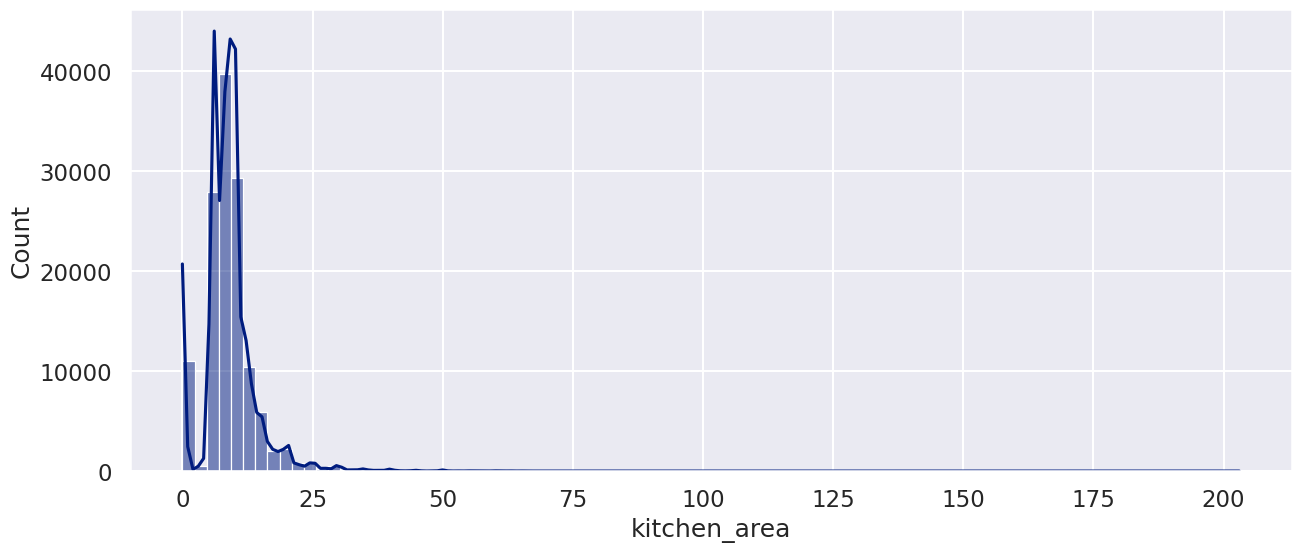

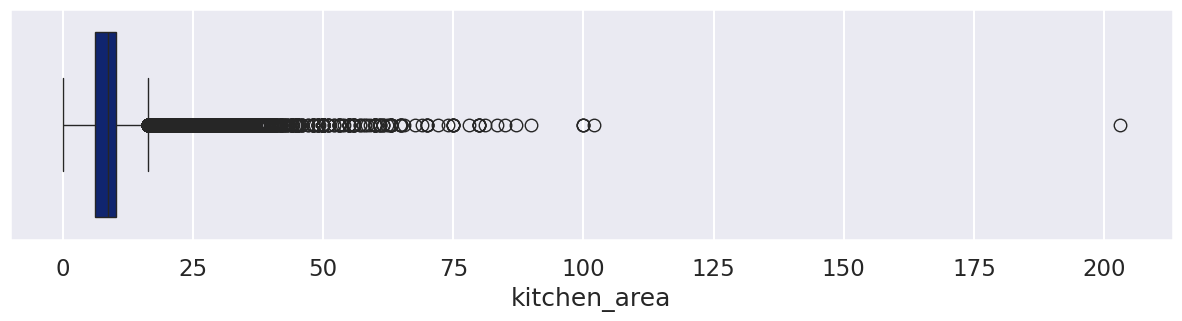

In [29]:
for col in ['total_area', 'living_area', 'kitchen_area']:
    hist_box_plot(df=df, feature=col, kde=True)

In [30]:
for col in ['total_area', 'living_area', 'kitchen_area']:
    print(f'Number of observations with 0 value for {col}: ', len(df.query(f'{col} == 0')))
    print(f'Ratio: ', round(100 * len(df.query(f'{col} == 0'))/len(df), 2), '%')

Number of observations with 0 value for total_area:  0
Ratio:  0.0 %
Number of observations with 0 value for living_area:  17069
Ratio:  12.91 %
Number of observations with 0 value for kitchen_area:  10965
Ratio:  8.29 %


It can be seen that there are quite a lot of 0 values in living_area and kitchen_area columns.  
Since there are no 0 values in the total_area column, it is highly unlikely that there was any  
error during data collection which led to 0 values in the area-related columns.

The probable reason for the 0 values in the living_area and kitchen_area columns is that  
these properties are used for commercial purposes.

Therefore, it would be a good idea to make an indicator column which will indicate whether  
the value is 0 (for both living_area and kitchen_area) - it will be done in the feature  
engineering part

As for the total_area column, an IQR filter will be applied with $threshold = 4$ so that only  
too extreme values are removed. 

Removed 1777 outliers, ratio - 1.34%


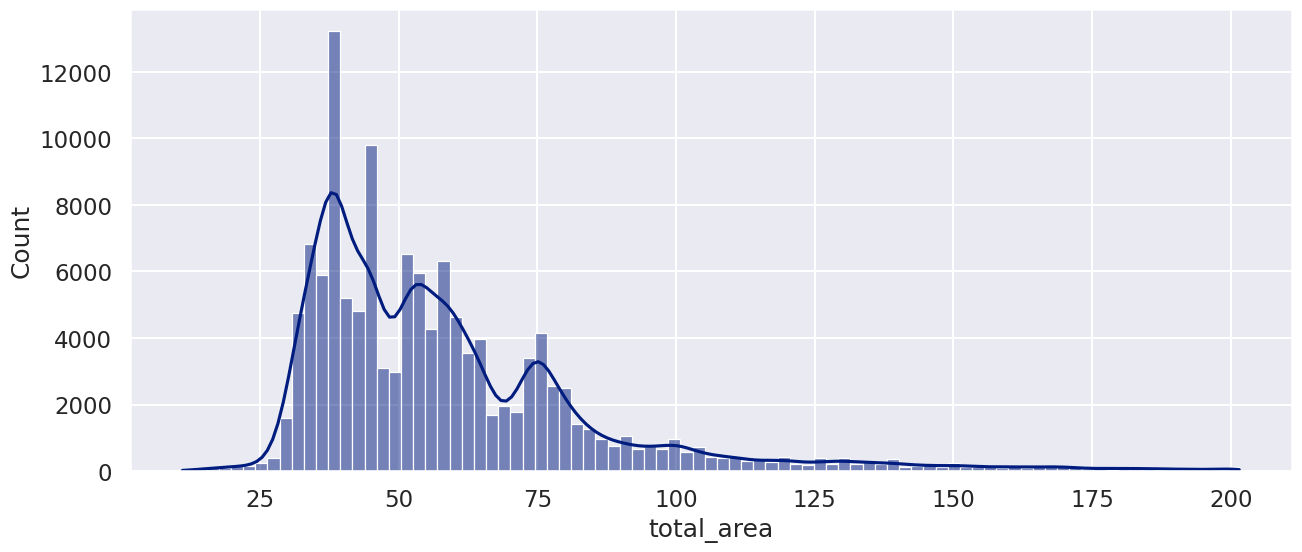

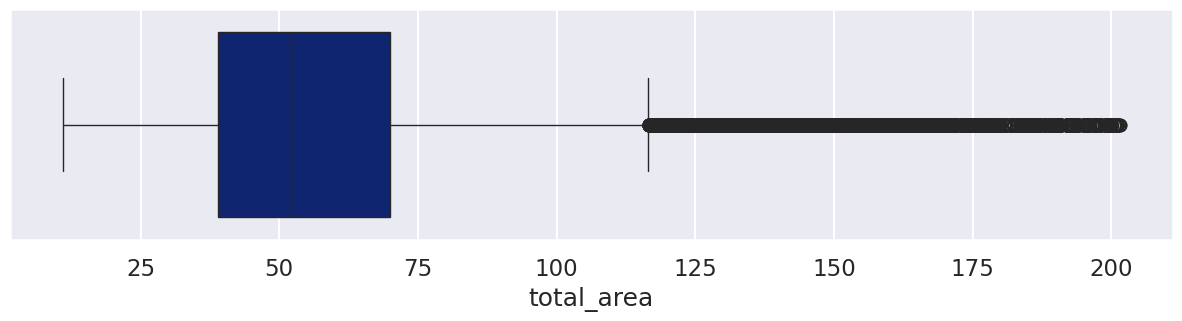

In [31]:
col = 'total_area'
iqr_features[col] = 4
hist_box_plot(df=iqr_filter(df.copy(), features={col: iqr_features[col]}), feature=col, kde=True)

Instead of IQR filter, let's apply a simple right side filter to remove outliers from living_area feature.  
As a result, data points with 0 value won't be removed while too extreme right side values will be removed.

Removed 569 outliers, ratio - 0.43%


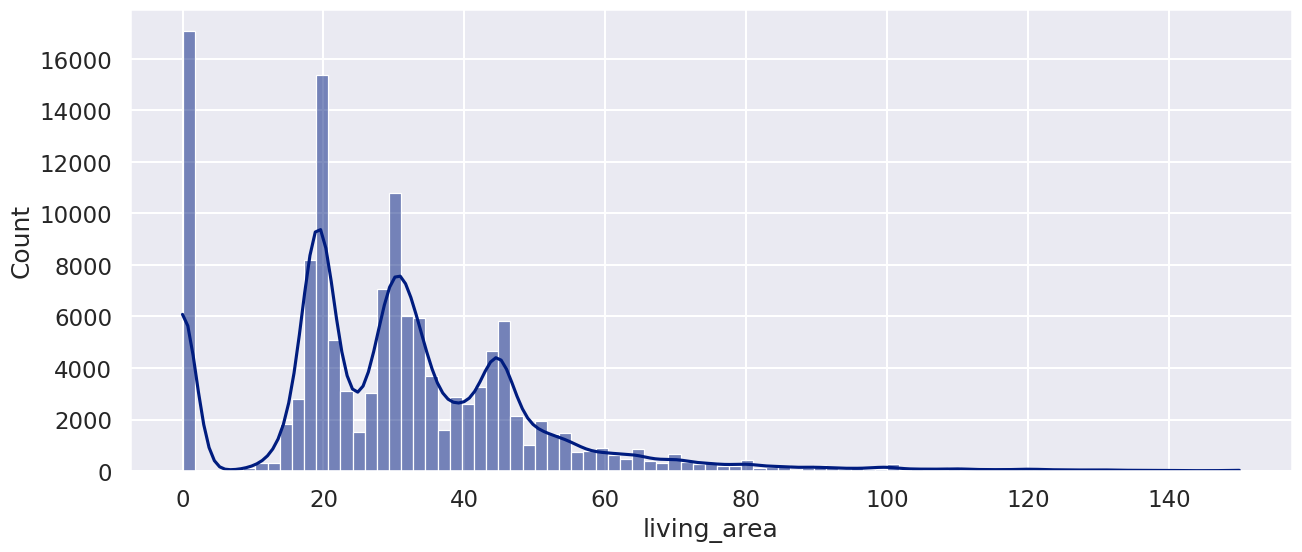

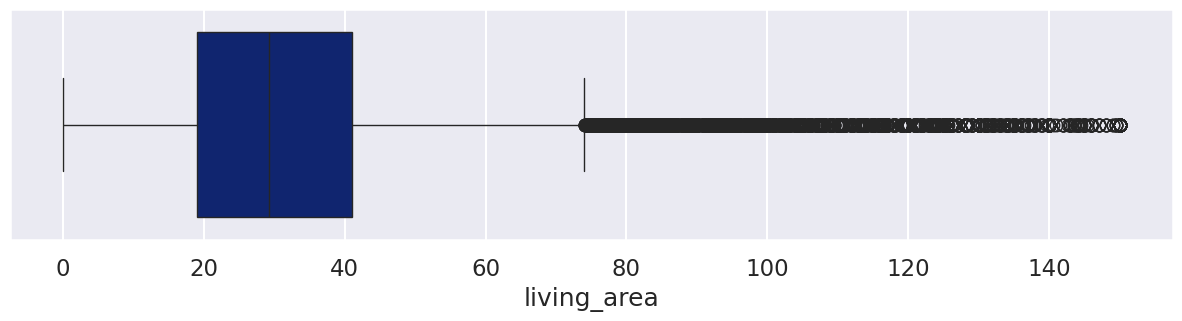

In [32]:
query = 'living_area <= 150 | living_area.isna()'
queries.append(query)
df2 = df.query(query)
message(df, df2)
hist_box_plot(df=df2, feature='living_area', kde=True)

Removed 488 outliers, ratio - 0.37%


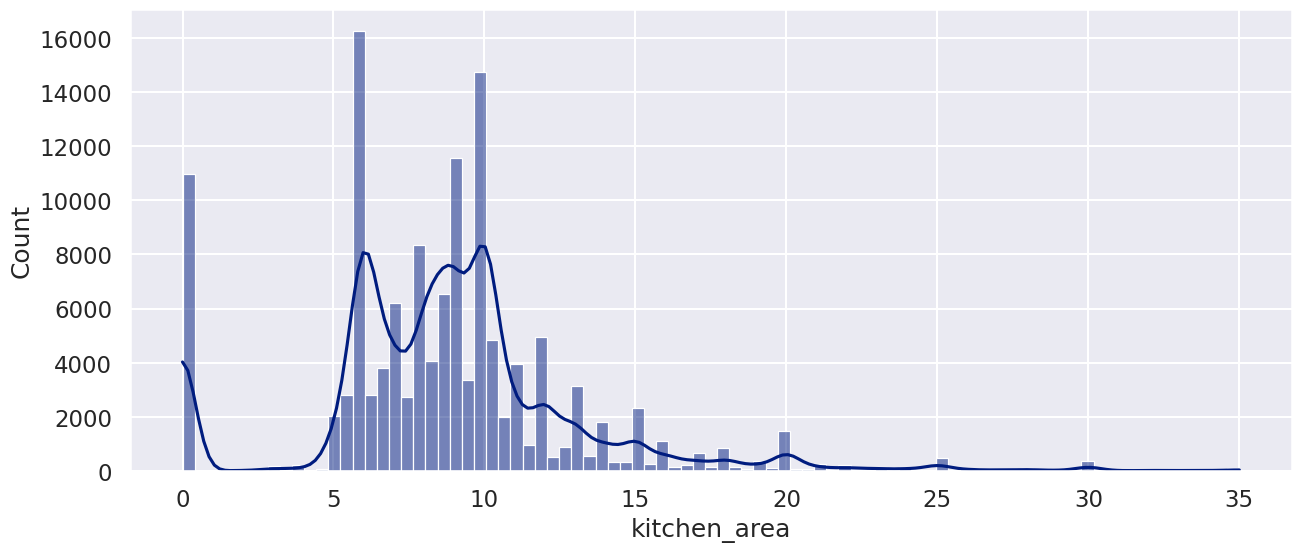

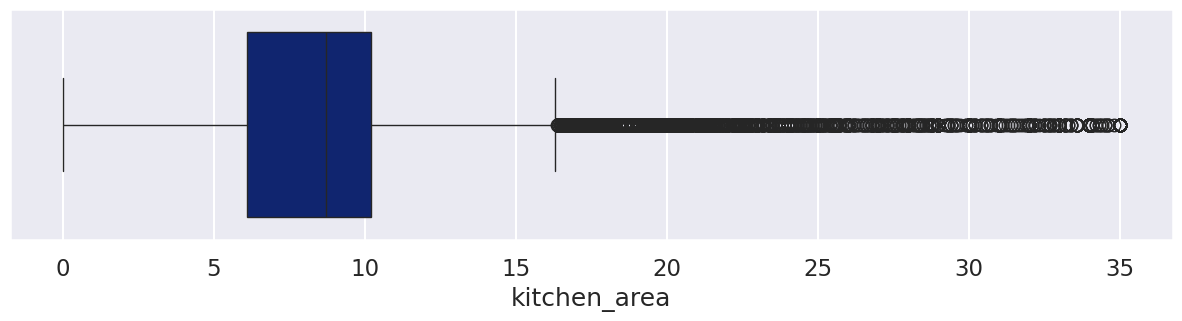

In [33]:
query = 'kitchen_area <= 35 | kitchen_area.isna()'
queries.append(query)
df2 = df.query(query)
message(df, df2)
hist_box_plot(df=df2, feature='kitchen_area', kde=True)

#### ceiling_height

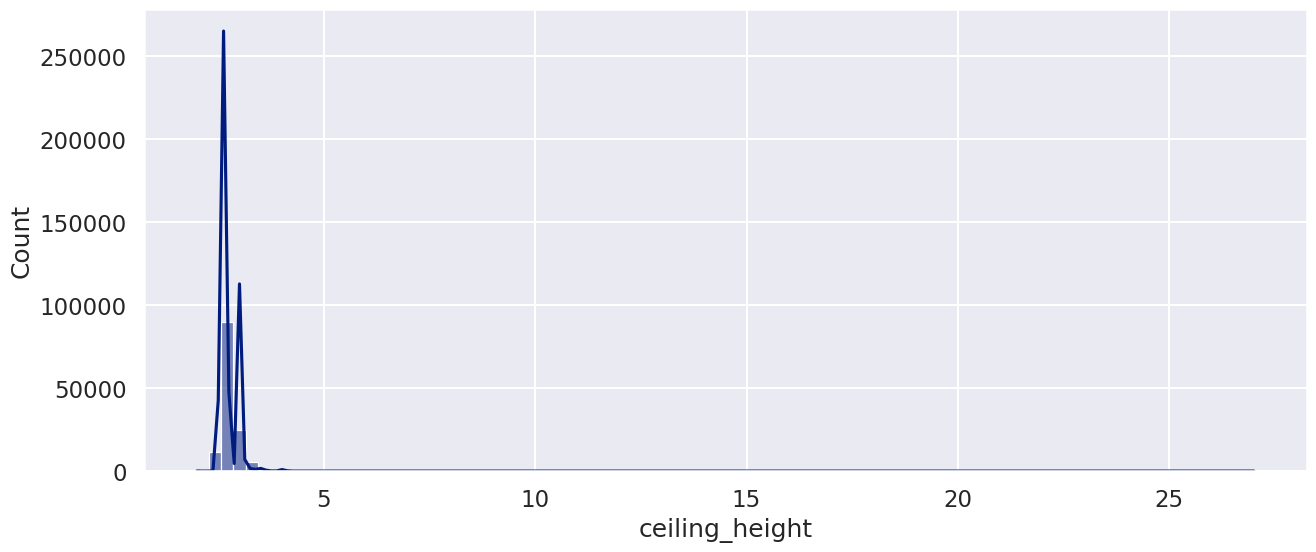

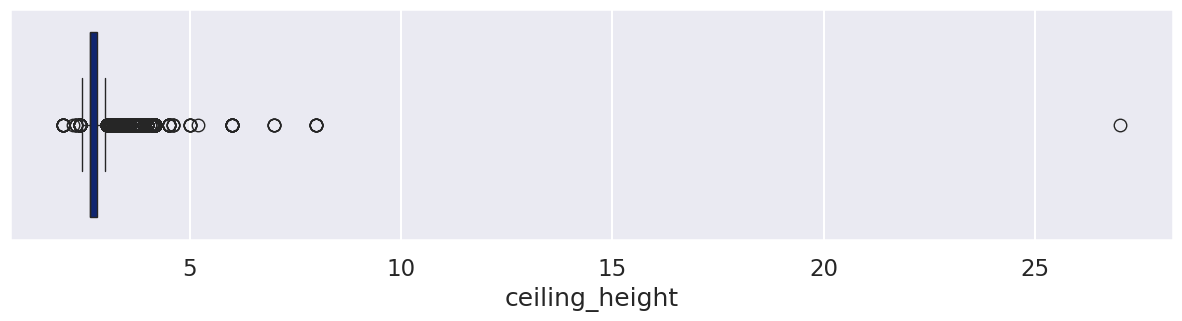

In [34]:
hist_box_plot(df=df, feature='ceiling_height', kde=True)

In [35]:
df['ceiling_height'].max()

27.0

There are clearly some outliers in this column. One observation with a height over than 25 meters  
is probably a typo (2.7 -> 27), or may be it is a unique property for commercial use.  
Since it is only one observation with such an anomality, let's omit it with every  
other outlier via IQR filter with $threshold = 4$

Removed 1165 outliers, ratio - 0.88%


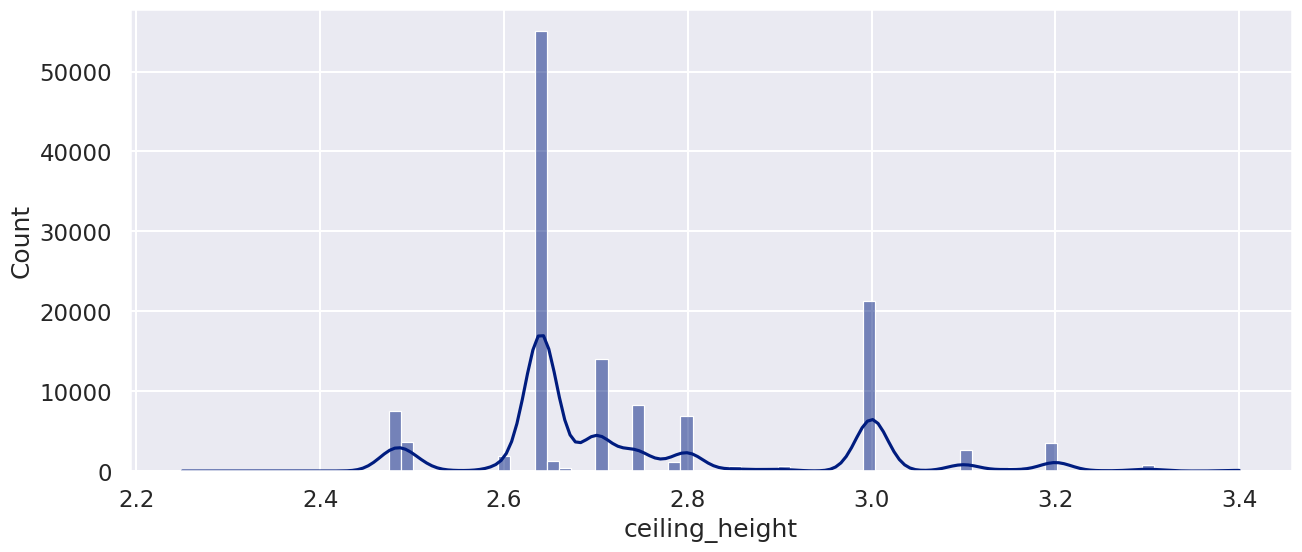

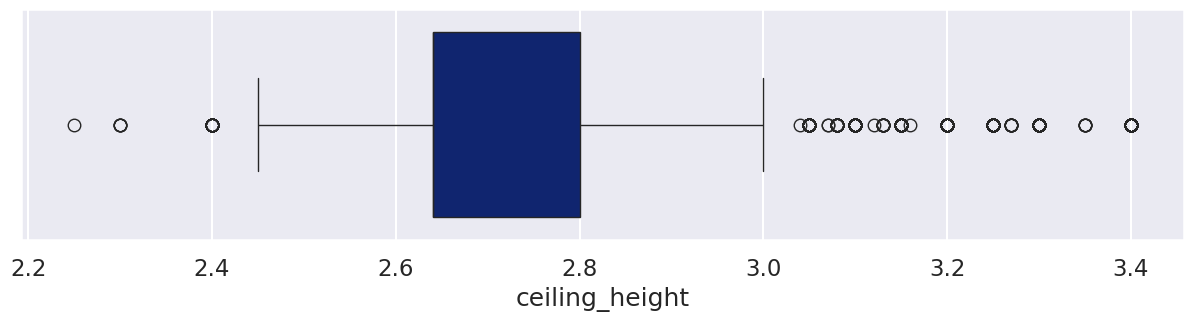

In [36]:
col = 'ceiling_height'
iqr_features[col] = 4
hist_box_plot(df=iqr_filter(df.copy(), features={col: iqr_features[col]}), feature=col, kde=True)

#### rooms

[2024-08-28T17:42:29.172+0000] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-08-28T17:42:29.234+0000] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


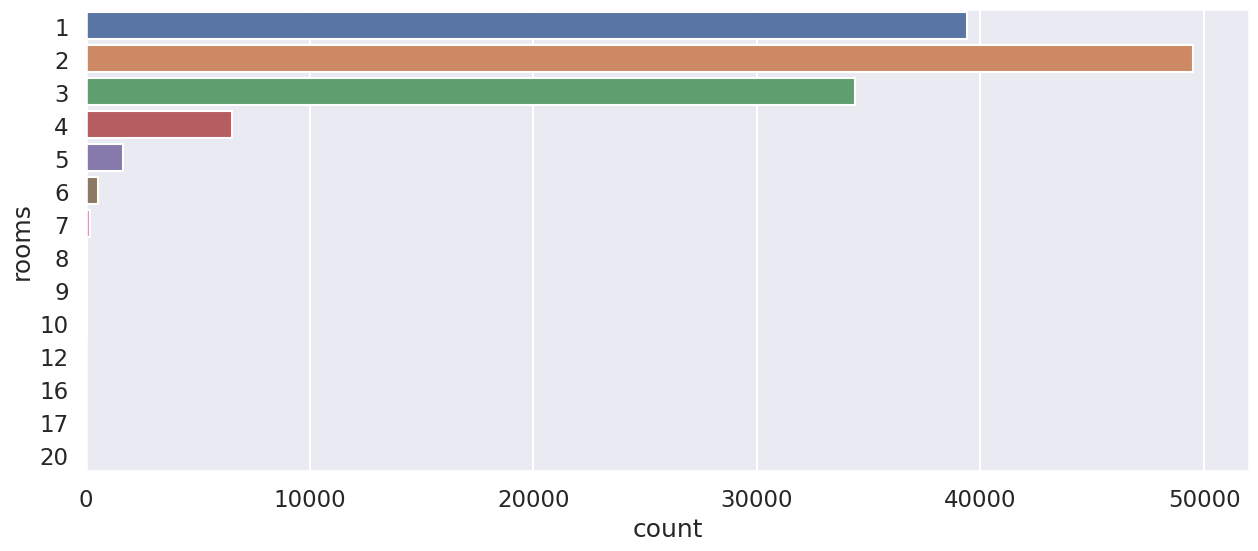

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.countplot(data=df['rooms'], ax=ax, orient='horizontal', palette='deep')
plt.show()

In [38]:
df['rooms'].value_counts()

rooms
2     49519
1     39415
3     34397
4      6515
5      1633
6       514
7       159
8        51
10       18
9        18
12        4
16        1
17        1
20        1
Name: count, dtype: int64

Properties with where the number of rooms >= 7 will be omitted since there are very few of them.

In [39]:
query = 'rooms <= 6 | rooms.isna()'
queries.append(query)
message(df, df.query(query))

Removed 253 outliers, ratio - 0.19%


#### flats_count

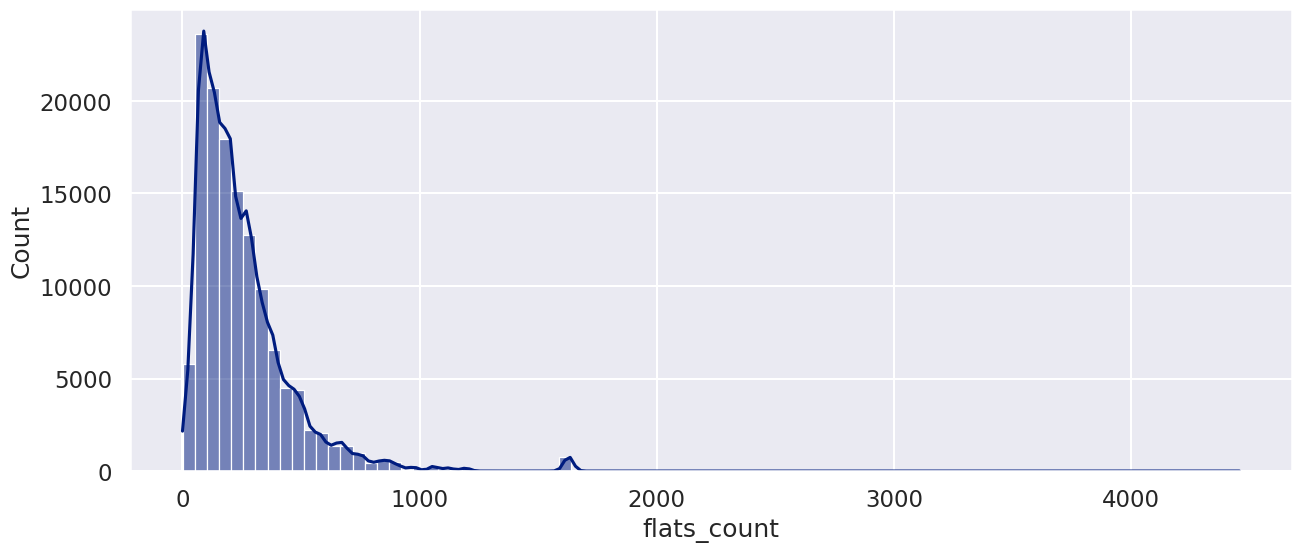

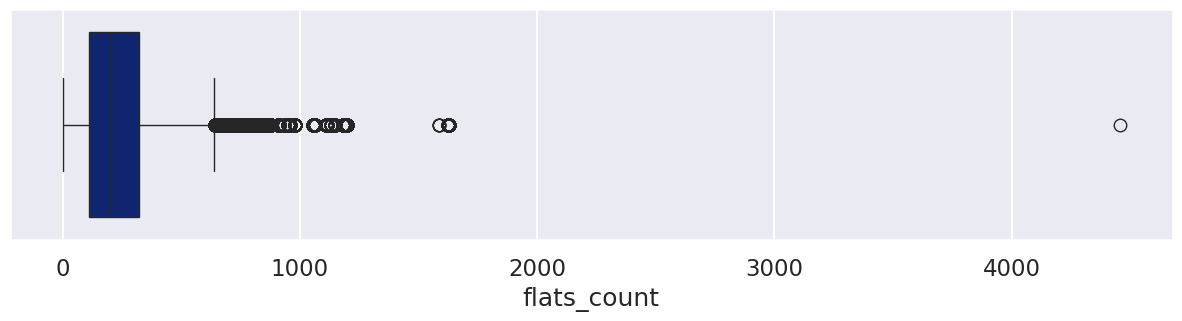

In [40]:
hist_box_plot(df=df, feature='flats_count', kde=True)

Applying IQR filter with $threshold = 3$

Removed 1542 outliers, ratio - 1.17%


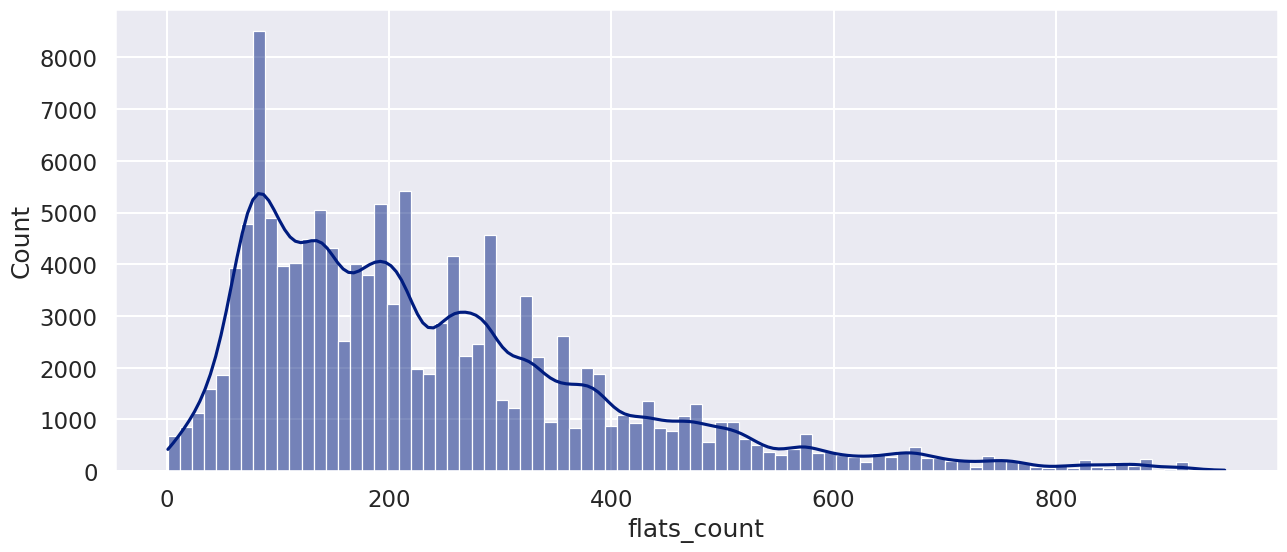

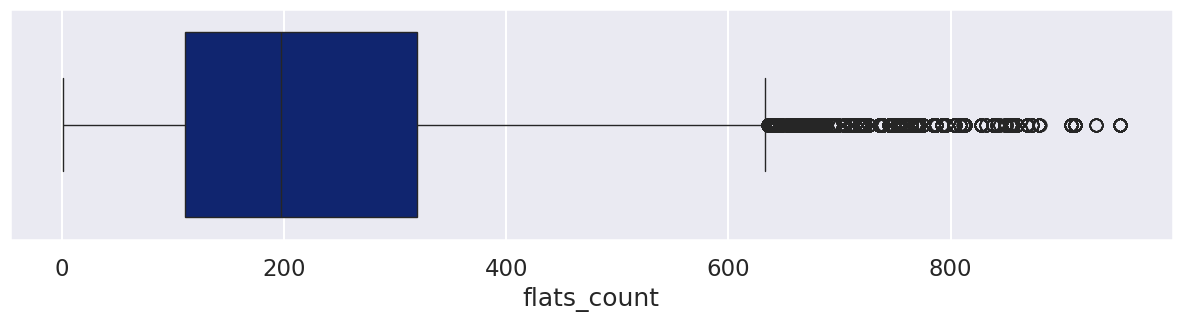

In [41]:
col = 'flats_count'
iqr_features[col] = 3
hist_box_plot(df=iqr_filter(df.copy(), features={col: iqr_features[col]}), feature=col, kde=True)

#### floor, floors_total

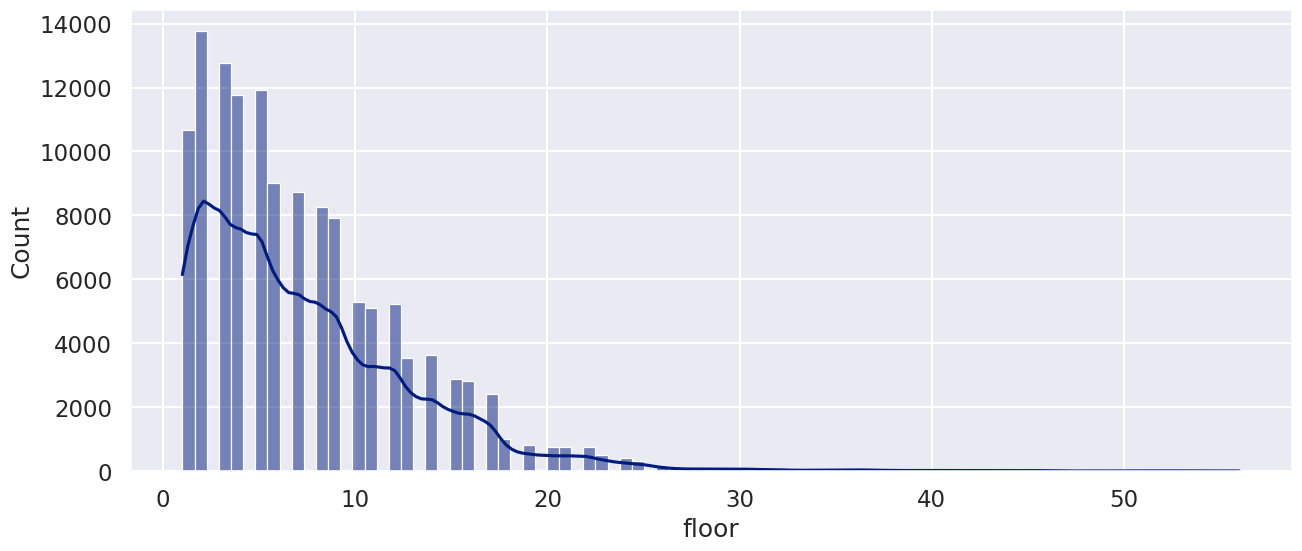

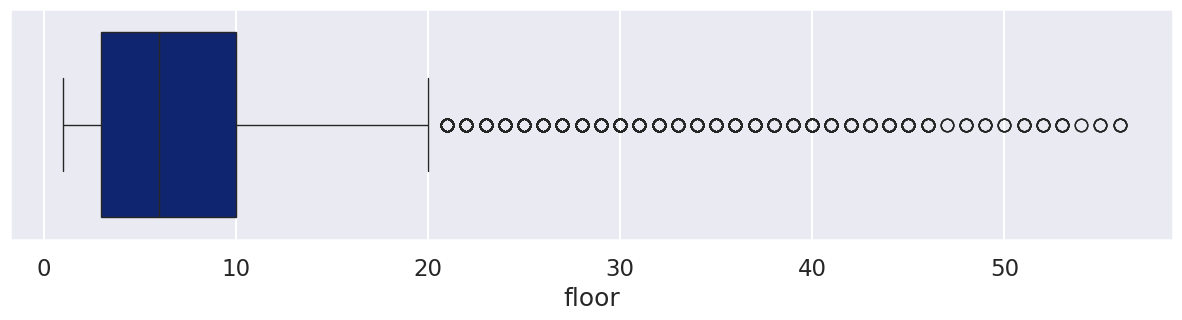

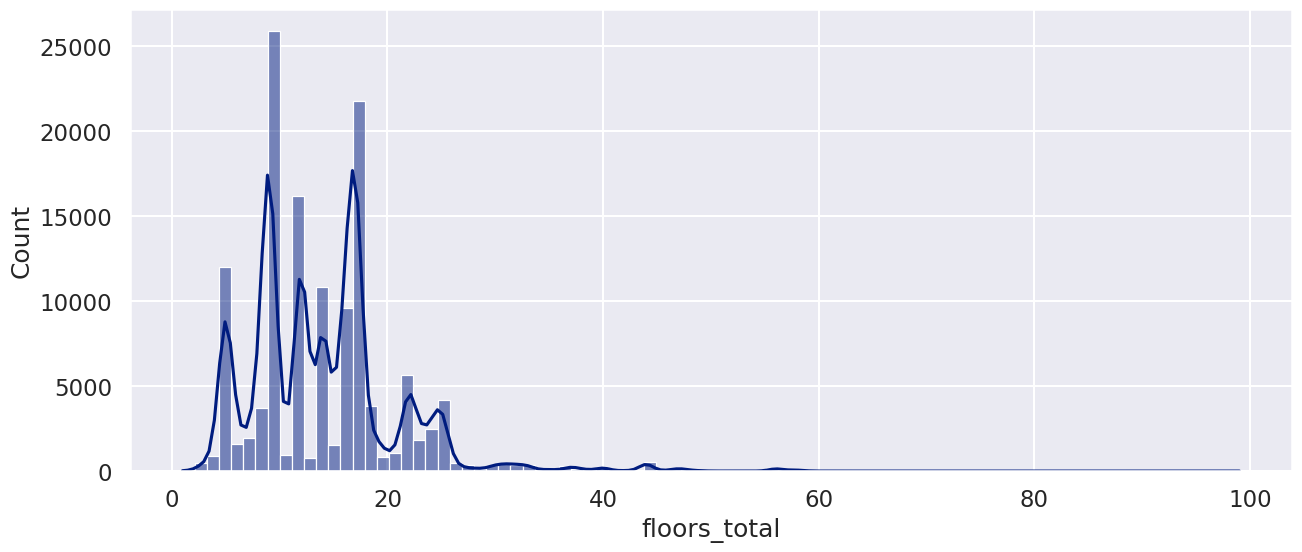

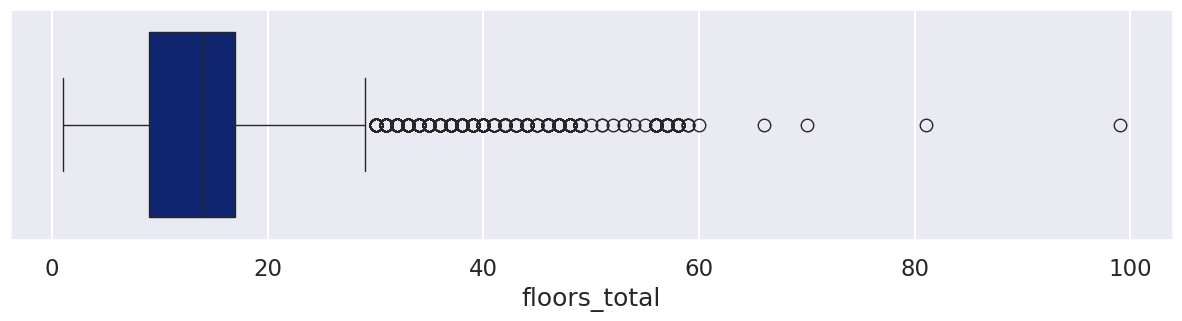

In [42]:
for col in ['floor', 'floors_total']:
    hist_box_plot(df=df, feature=col, kde=True)

Applying IQR filter with $threshold = 3$

Removed 609 outliers, ratio - 0.46%


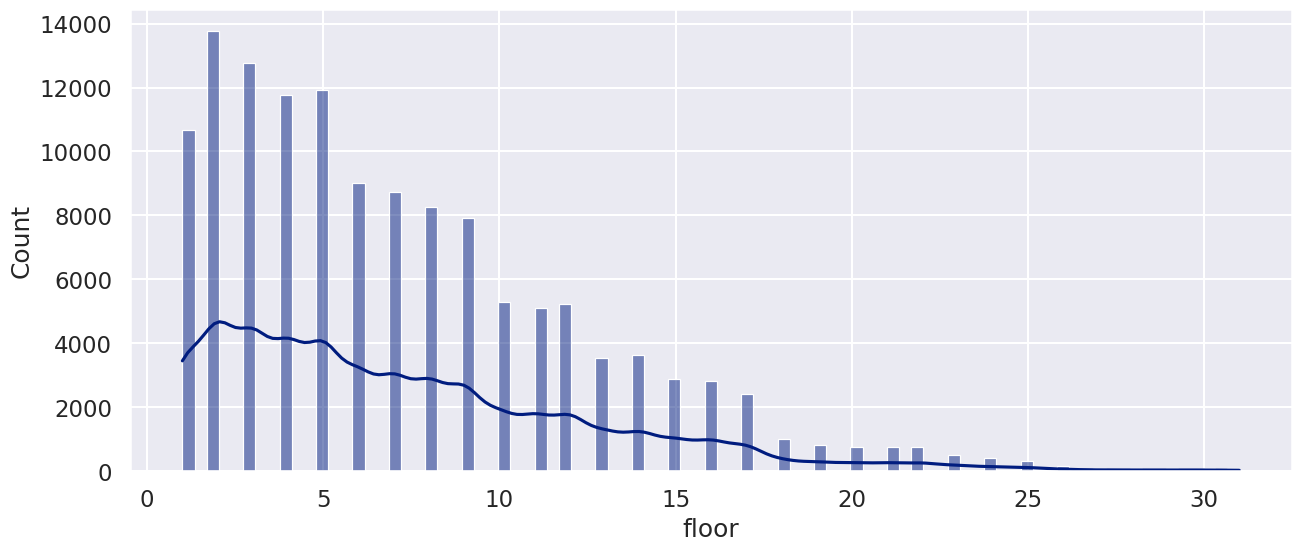

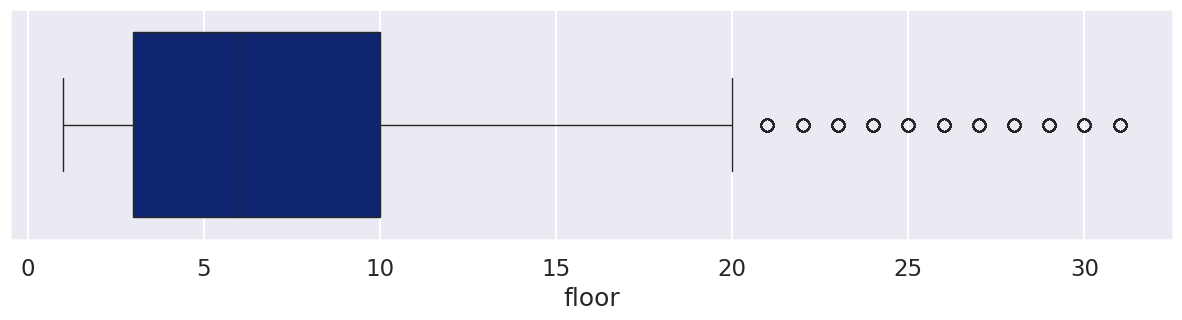

In [43]:
col = 'floor'
iqr_features[col] = 3
hist_box_plot(df=iqr_filter(df.copy(), features={col: iqr_features[col]}), feature=col, kde=True)

Removed 1176 outliers, ratio - 0.89%


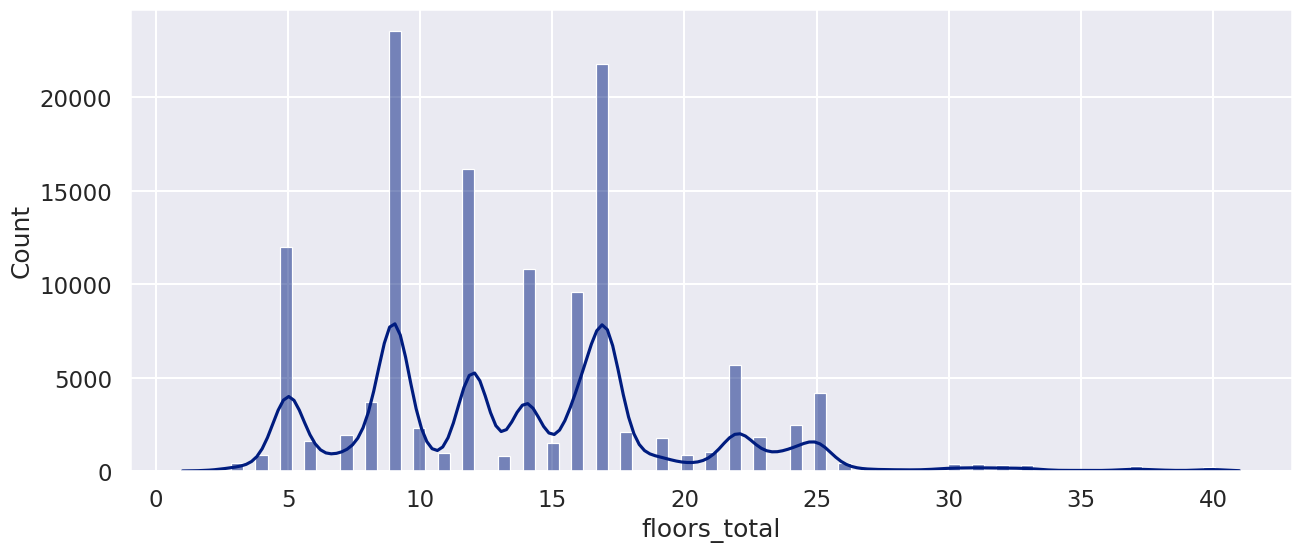

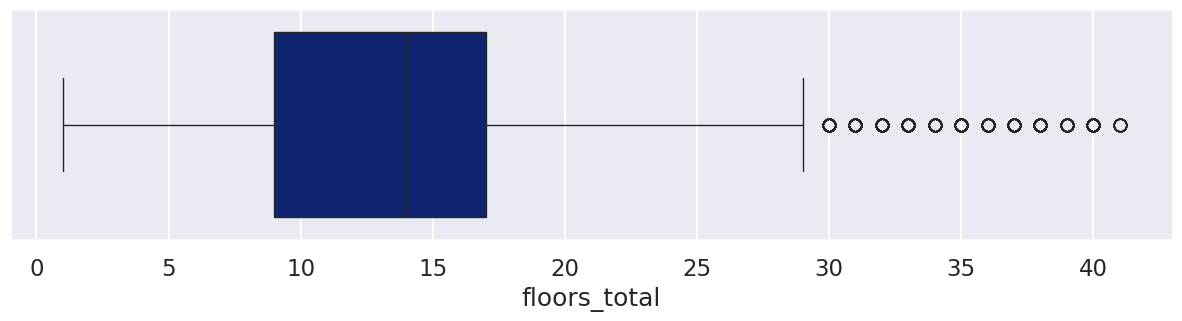

In [44]:
col = 'floors_total'
iqr_features[col] = 3
hist_box_plot(df=iqr_filter(df.copy(), features={col: iqr_features[col]}), feature=col, kde=True)

#### build_year

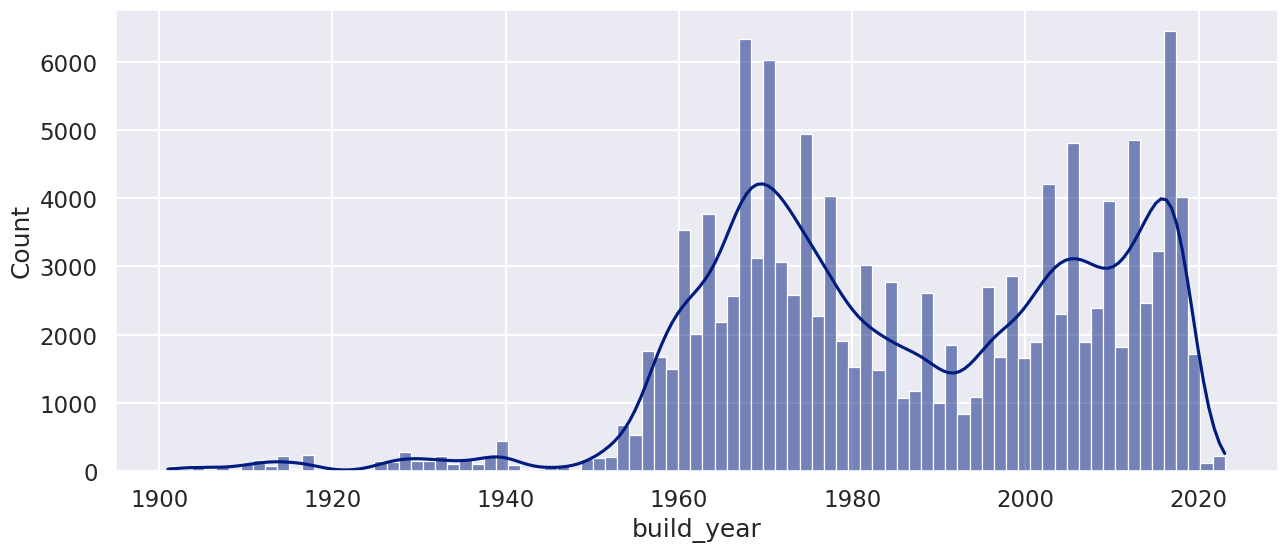

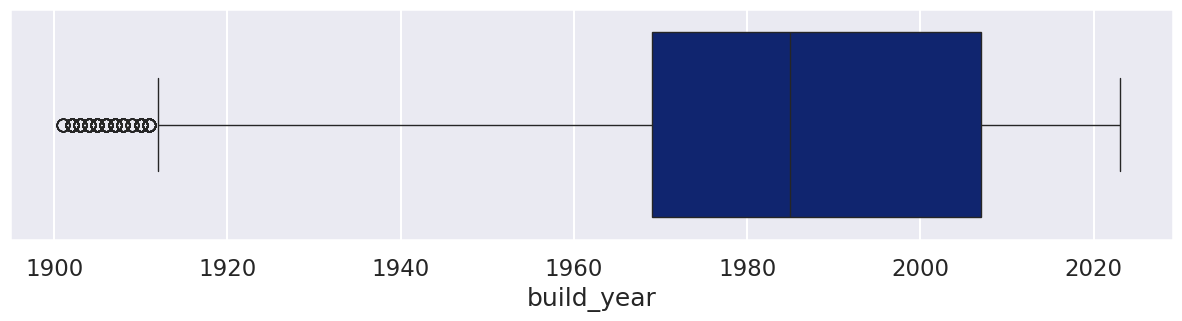

In [45]:
hist_box_plot(df=df, feature='build_year', kde=True)

Let's apply IQR filter to remove too old properties

Removed 456 outliers, ratio - 0.34%


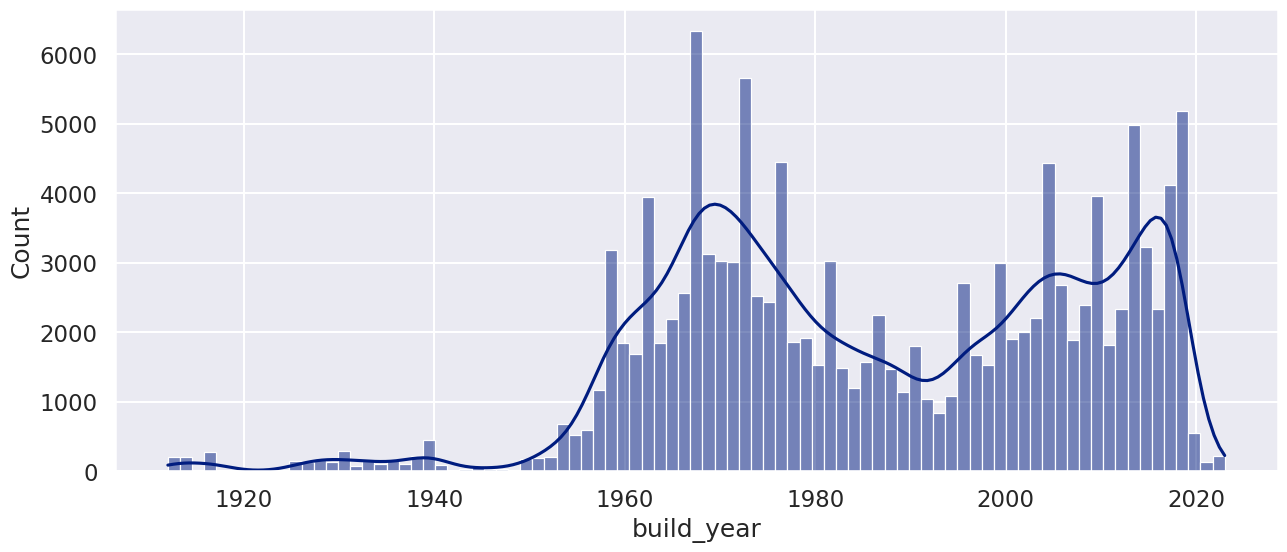

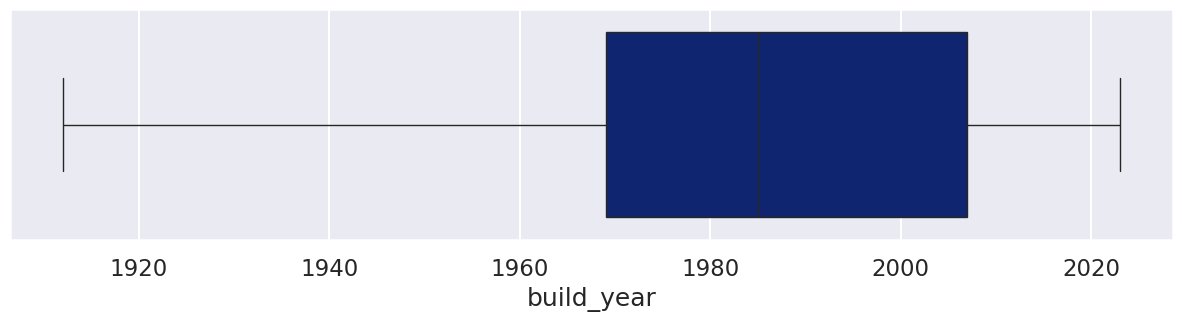

In [46]:
col = 'build_year'
iqr_features[col] = 1.5
hist_box_plot(df=iqr_filter(df.copy(), features={col: iqr_features[col]}), feature=col, kde=True)

### Combining

In [47]:
iqr_features

{'log1p_target': 4,
 'latitude': 1.5,
 'longitude': 2,
 'total_area': 4,
 'ceiling_height': 4,
 'flats_count': 3,
 'floor': 3,
 'floors_total': 3,
 'build_year': 1.5}

In [48]:
queries

['building_type_int != 5 | building_type_int.isna()',
 'living_area <= 150 | living_area.isna()',
 'kitchen_area <= 35 | kitchen_area.isna()',
 'rooms <= 6 | rooms.isna()']

In [49]:
df2 = df.copy()

for query in queries:
    df2 = df2.query(query)

df2 = iqr_filter(data=df2, features=iqr_features, verbose=False)

print(f"Number of observations before dropping outliers: {len(df)}")
print(f"Number of observations after dropping outliers: {len(df2)}")
print(f"Ratio: {round(100*len(df2)/len(df), 2)}%")
print(f"Number of outlier observations dropped: {len(df) - len(df2)}")
print(f"Ratio: {round(100*(1 - len(df2)/len(df)), 2)}%")

Number of observations before dropping outliers: 132246
Number of observations after dropping outliers: 125907
Ratio: 95.21%
Number of outlier observations dropped: 6339
Ratio: 4.79%


It can be seen that less than 5 % of the data was identified as outliers and has been removed,  
which is a good sign since not too much data was lost.

## II. Multidimensional outliers

So far, outliers have been considered per each features separately. 
However, it is possible to distinguish outliers based on the combination of features.  
There are some methods to detect outliers in the high-dimensional space.  
Let's consider one of them - Isolation Forest.  
Since about 5% of the data has already been dropped, the contamination rate will be set to 0.01 (1 %)  

In [50]:
df3 = df2.copy()

model = IsolationForest(contamination=0.01, random_state=42)
df3['outlier'] = model.fit_predict(df3[numerical_features + binary_cat_features + non_binary_cat_features])
df3 = df3.query('outlier == 1').drop(columns=['outlier'])

print(f"Number of observations before dropping outliers: {len(df)}")
print(f"Number of observations after dropping outliers: {len(df3)}")
print(f"Ratio: {round(100*len(df3)/len(df), 2)}%")
print(f"Number of outlier observations dropped: {len(df) - len(df3)}")
print(f"Ratio: {round(100*(1 - len(df3)/len(df)), 2)}%")

Number of observations before dropping outliers: 132246
Number of observations after dropping outliers: 124647
Ratio: 94.25%
Number of outlier observations dropped: 7599
Ratio: 5.75%


It can be seen that almost 5% + 1% = 6% of the data was identified as outliers and has been removed,  
which is acceptable since the size of the data is large.